In [190]:
import pandas as pd
import re
from collections import Counter
import squarify
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from html import unescape
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from wordcloud import WordCloud

In [48]:
!pip install squarify

In [ ]:
#Читаем файл, разделяем строки по табуляции и задаём имена для столбцов
df = pd.read_csv('train_150k.txt', sep='\t', header = None, names = ['feeling', 'tweet'], encoding='utf-8')

## **1) Первичный анализ данных**

In [ ]:
df.head()

,feeling,tweet
0,0,Starting back at work today Looks like it'l...
1,1,Sugar levels dropping... munchies setting in. ...
2,1,@karineb22 yeah!!! have a great summer break!
3,1,hannah montana was very good. now going to re...
4,1,"@Mayra326 aww, have fun! I just had my 3D las..."


**Описание перменных:**

*   **tweet** - предложение (твит), которое человек написал в социальной сети X

*   **feeling** - бинарная переменная, равная 1, если твит положительного настроения, и 0, если твит негативного настроения



In [ ]:
df.shape

(149985, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149985 entries, 0 to 149984
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   feeling  149985 non-null  int64 
 1   tweet    149985 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
df.isnull().sum()

,0
feeling,0
tweet,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.sample(10)

,feeling,tweet
6570,1,@KaceyofSweden15 &amp; thank you too. Nurse J...
16721,0,Oooh man I've been naughty but still remained ...
121757,1,playing around with survey monkey... survey co...
103791,1,Sipping on a Ice Cold Heineken ina 1 hand.. an...
110256,1,i'm done i can't belive it i'll go watch a mo...
107970,1,yoville on facebook
72458,0,study study study. it seems to be never-ending...
141289,0,"@ruthward english language, maths and french"
18173,0,Just got back from salsa. My ankle is sore. Ma...
113009,0,@l0riell i had a nightmare we werent myspacein...


Набор наблюдений является обучающим (**train set**). Выборка содержит 149 985 наблюдений, пропущенных значений и дубликатов нет.

Переменная ***feeling*** является категориальной (номинальной, бинарной), тип данных -- int64. Она обозначает два состояния (позитивное и негативное настроение).

Переменная ***tweet*** тоже является категориальной: тип данных -- object. Данная переменная представляет собой категории (каждый твит -- отдельная категория).







## **2) Анализ целевой переменной feeling**

В данной главе сравнивается количество позитивных и негативных твитов. Для лучшего восприятия строится круговая (*pie*) диаграммы.

In [ ]:
#Количество позитивных и отрицательных твитов
positive_count = df[df['feeling'] == 1].shape[0]
negative_count = df[df['feeling'] == 0].shape[0]

print(f'Количество положительных твитов: {positive_count}')
print(f'Количество отрицательных твитов: {negative_count}')

Количество положительных твитов: 74966
Количество отрицательных твитов: 75019


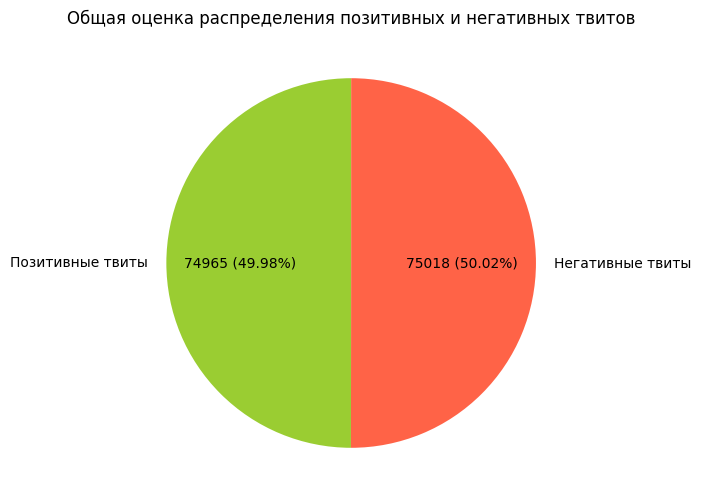

In [ ]:
counts = [positive_count, negative_count]

#Круговая диаграмма для отображения распределения тональности
plt.figure(figsize=(8, 6))
plt.pie(x=counts,
        labels=['Позитивные твиты', 'Негативные твиты'],
        colors=['yellowgreen', 'tomato'],
        autopct=lambda p: f'{int(p * sum(counts) / 100)} ({p:.2f}%)', startangle=90)
plt.title('Общая оценка распределения позитивных и негативных твитов')
plt.show()

Позитивные и негативные твиты встречаются практически с одинаковой периодичностью: количество твитов положительной тональности составляет 74 966 (49,98%) и отрицательной тональности - 75 019 (50,02%).

## **3) Анализ текстовых данных**

В главе 3
1.   проанализировано распределение количества слов и символов в твитах как для всей выборки, так и отдельно для позитивной и негативной тональностей;
3.   построен боксплот, отражающий среднюю, минимальную и максимальную длину текста как для всей выборки, так и для каждой тональности отдельно.



### **3.1. Количество слов и символов в твитах до обработки текста**

In [ ]:
df['word_count'] = df['tweet'].str.split().str.len() #Количество слов в твитах

In [ ]:
df['char_count'] = df['tweet'].str.len() #Количество символов в твитах

In [ ]:
df

,feeling,tweet,word_count,char_count
0,0,Starting back at work today Looks like it'l...,16,87
1,1,Sugar levels dropping... munchies setting in. ...,16,103
2,1,@karineb22 yeah!!! have a great summer break!,7,46
3,1,hannah montana was very good. now going to re...,10,59
4,1,"@Mayra326 aww, have fun! I just had my 3D las...",11,53
...,...,...,...,...
149980,0,Had a great night at Tabs but now I'm missing ...,14,65
149981,1,What a night at work.. Church in the morning,9,45
149982,0,this book is terrible im used 2 reading all ...,25,137
149983,0,@backstreetboys Updates? Any? I miss your upd...,8,57


**3.1.1. Распределение количества слов и символов в твитах по всей выборке**

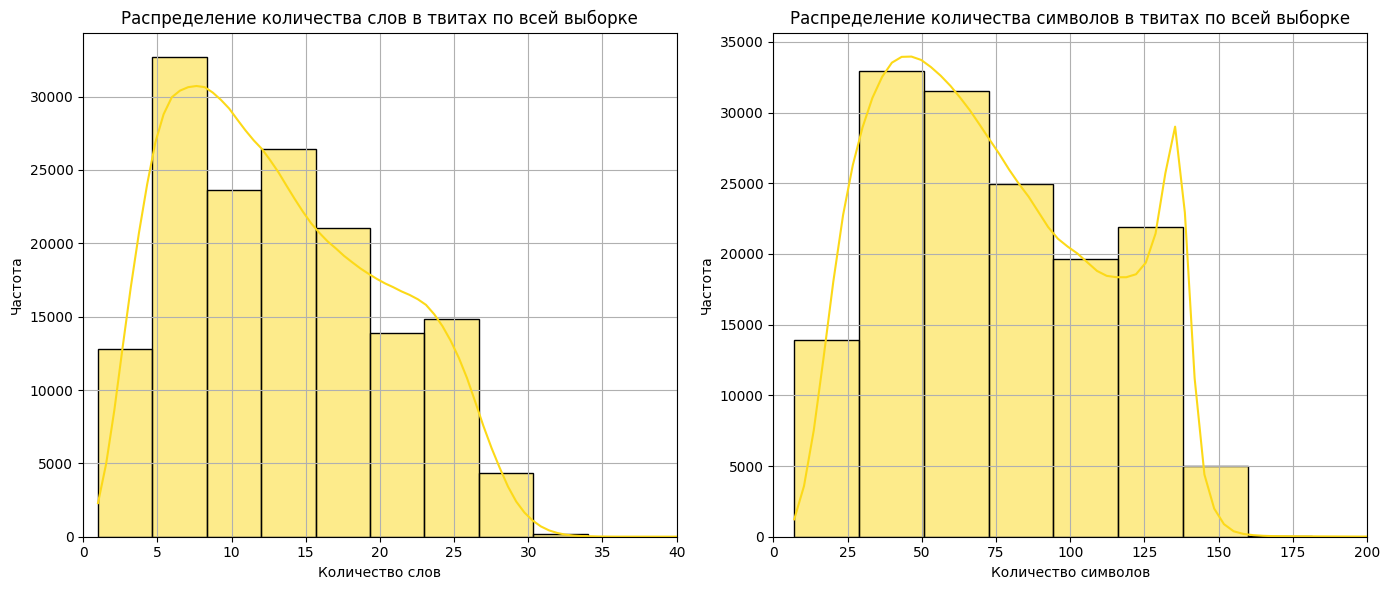

In [ ]:
#График распределения количества слов в твитах
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['word_count'], bins=30, color='#fcd918', kde=True)
plt.title('Распределение количества слов в твитах по всей выборке')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.xlim(0, 40)
plt.grid()

#График распределения количества символов в твитах
plt.subplot(1, 2, 2)
sns.histplot(df['char_count'], bins=30, color='#fcd918', kde=True)
plt.title('Распределение количества символов в твитах по всей выборке')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.xlim(0, 200)
plt.grid()

plt.tight_layout()
plt.show()

Чаще всего длина твитов не превосходит 35 слов, или 175 символов.
Наиболее распространённая длина одного твита - 5-27 слов (26-135 символов).

**3.1.2. Распределение количества слов и символов в твитах позитивной тональности**

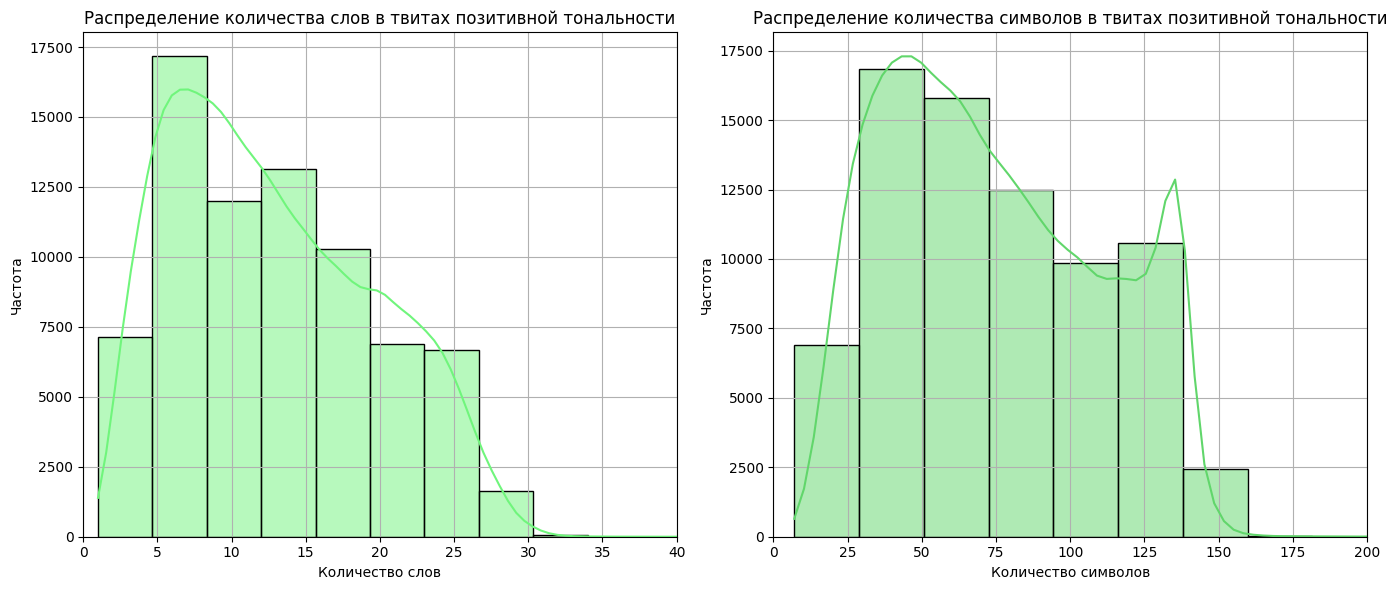

In [ ]:
#График распределения количества слов в твитах
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[df['feeling'] == 1]['word_count'], bins=30, color='#70f57c', kde=True)
plt.title('Распределение количества слов в твитах позитивной тональности')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.xlim(0, 40)
plt.grid()

#График распределения количества символов в твитах
plt.subplot(1, 2, 2)
sns.histplot(df[df['feeling'] == 1]['char_count'], bins=30, color='#61d66b', kde=True)
plt.title('Распределение количества символов в твитах позитивной тональности')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.xlim(0, 200)
plt.grid()

plt.tight_layout()
plt.show()

Выводы для твитов положительной тональности аналогичны общим выводам:
*  чаще всего длина твитов положительной тональности не превосходит 35 слов, или 175 символов;
* наиболее распространённая длина одного твита - 5-16 слов (26-95 символов).

**3.1.3. Распределение количества слов и символов в твитах негативной тональности**

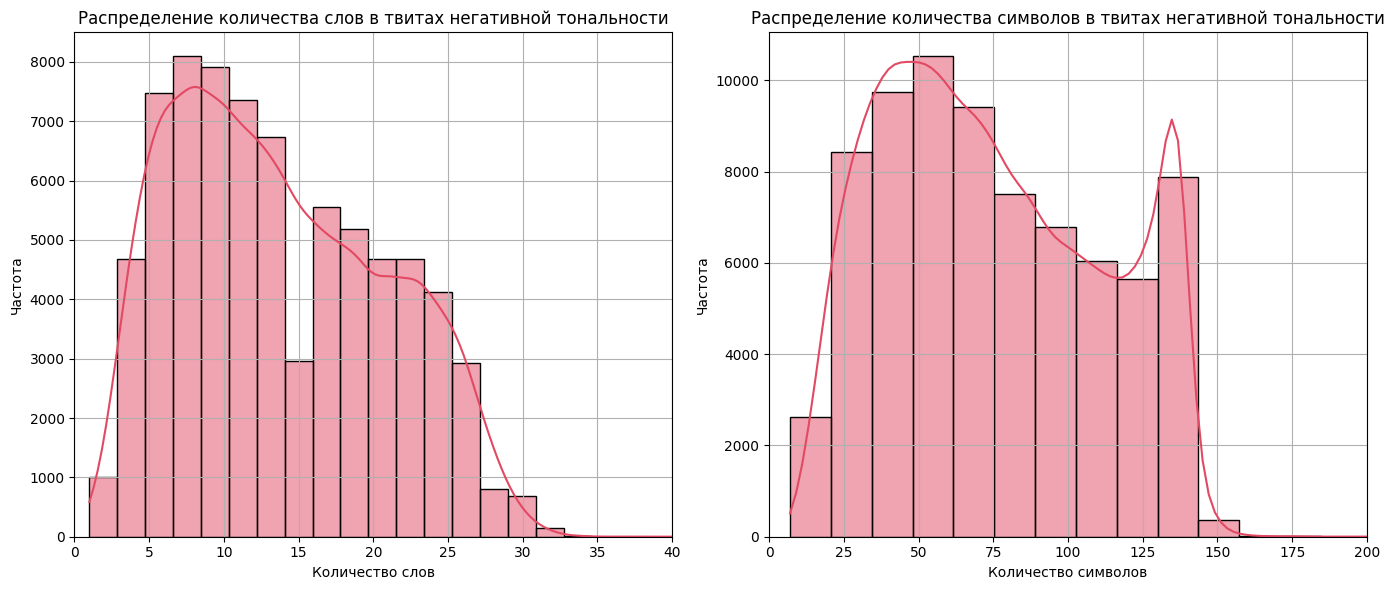

In [ ]:
#График распределения количества слов в твитах
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[df['feeling'] == 0]['word_count'], bins=30, color='#e24962', kde=True)
plt.title('Распределение количества слов в твитах негативной тональности')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.xlim(0, 40)
plt.grid()

#График распределения количества символов в твитах
plt.subplot(1, 2, 2)
sns.histplot(df[df['feeling'] == 0]['char_count'], bins=30, color='#e24962', kde=True)
plt.title('Распределение количества символов в твитах негативной тональности')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.xlim(0, 200)
plt.grid()

plt.tight_layout()
plt.show()

Количество слов твитов отрицательной тональности не превосходит 35, а количество символов - 175, что характерно и для общей выборки, и для позитивных твитов отдельно.
Наиболее часто негативные твиты содержат 5-27 слов, или 24-145 символов.


На данном этапе можно заметить, что длина негативных твитов несколько больше длины позитивных твитов.

**3.1.4. Распределение минимальной, средней и максимальной длины твитов**

In [ ]:
df_char_count = pd.DataFrame({
    'char_count': df['char_count'],
    'char_count_neg': df[df['feeling'] == 0]['char_count'].reset_index(drop=True),
    'char_count_pos': df[df['feeling'] == 1]['char_count'].reset_index(drop=True)
})

In [ ]:
df_char_count.describe()

,char_count,char_count_neg,char_count_pos
count,149985.000000,75019.000000,74966.000000
mean,74.821489,75.242045,74.400635
std,36.397013,36.465816,36.323400
min,7.000000,7.000000,7.000000
25%,44.000000,45.000000,44.000000
50%,70.000000,71.000000,69.000000
75%,104.000000,105.000000,103.000000
max,662.000000,417.000000,662.000000


In [ ]:
descriptive_stats = df_char_count.describe().loc[['min', 'mean', 'max']].values.T

In [ ]:
descriptive_stats

array([[  7.        ,  74.82148882, 662.        ],
       [  7.        ,  75.24204535, 417.        ],
       [  7.        ,  74.40063495, 662.        ]])

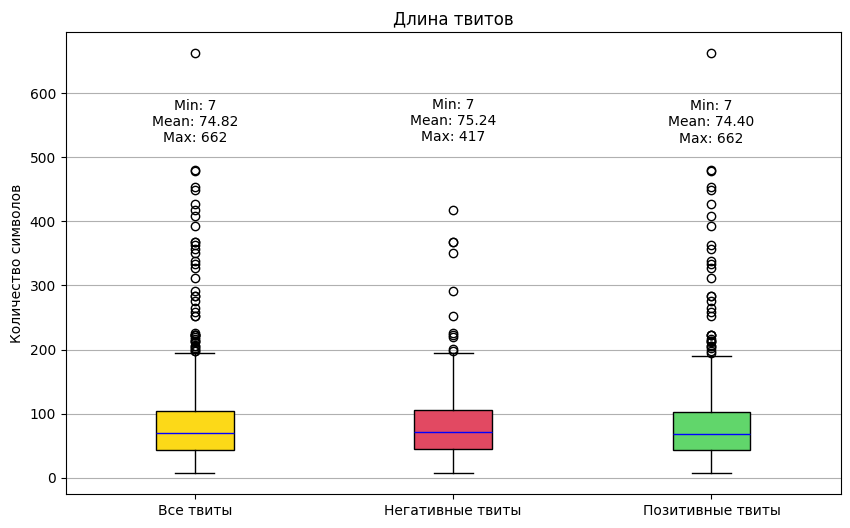

In [ ]:
#Данные для boxplot'ов
data = [df['char_count'], df[df['feeling'] == 0]['char_count'], df[df['feeling'] == 1]['char_count']]

plt.figure(figsize=(10, 6))
bplot = plt.boxplot(data,
                    labels=['Все твиты', 'Негативные твиты', 'Позитивные твиты'],
                    vert=True,
                    patch_artist=True)

#Цвета для ящиков с усами
bplot['boxes'][0].set_facecolor('#fcd918')
bplot['boxes'][1].set_facecolor('#e24962')
bplot['boxes'][2].set_facecolor('#61d66b')

#Цвет медианы
for median in bplot['medians']:
    median.set_color('blue')

for i, box in enumerate(bplot['boxes']):
    bbox = box.get_path().get_extents()
    x = bbox.x0 + (bbox.x1 - bbox.x0) / 2
    y = bbox.y1 + 415
    plt.text(x, y, f"Min: {descriptive_stats[i,0]:.0f}\nMean: {descriptive_stats[i,1]:.2f}\nMax: {descriptive_stats[i,2]:.0f}", ha='center', va='bottom')


plt.title('Длина твитов')
plt.ylabel('Количество символов')
plt.grid(axis='y')
plt.show()

Минимальное количество символов - 7 - совпадает для позитивных и негативных твитов. Средняя длина твитов обеих тональностей практически не отличается - твиты отрицательной тональности в среднем длиннее примерно на 1 символ. Средняя длина позитинвых твитов составляет 74,40 символа, средняя длина негативных твитов - 75,24 символа. При этом максимальная длина позитивных твитов превосходит максимальную длину негативных твитов на 245 символов - 662 против 417 символов.
Длина 75% наблюдений позитивных твитов меньше 103 символов, длина негативных твитов - 105 символов.
Стоит отметить, что большее число выбросов характерно для позитивных твитов.

Таким образом, длина твитов отрицательной тональности превышает длину твитов положительной тональности. Это можно объяснить тем, что люди, испытывая негативные эмоции, склонны делиться своими мыслями более подробно с собеседниками, ожидая получить ответную реакцию. Для этого они используют ссылки, хэштеги и пр., отмечают друг друга, что удлиняет твит.

Перед тем как начать исследовать датасет полноценно, очистим текст от ненужных для анализа данных. Для этого в каждом твите оставим только буквы: уберём все цифры, знаки препинания и любые другие символы, которые не относятся к буквам (в частности, лишние пробелы), кроме хэштегов, т. к. они могут указывать на темы, которые волнуют людей в определённый момент времени, и, следовательно, на позитивные или негативные эмоции людей.

Помимо этого приведём текст к нижнему регистру - объединим слова, которые означают одно и то же (например, *sun* = *SUN*, *sun*, *Sun*). Также переведём все твиты на английский язык.

## **3.2. Анализ знаков**

В данном разделе мы найдем самые часто встречающиеся знаки в нашем датасете, а также проведем визуализацию топ знаков.

In [76]:
joined_text = ''.join(df['tweet'].tolist())
pattern_for_text = r'[a-zâÂãÃA-Z0-9\s]+'
result = re.sub(pattern_for_text, '', joined_text)
c = Counter(result)
c.most_common(15)

[('.', 196865),
 ('!', 86838),
 ('@', 75987),
 ("'", 61165),
 (',', 45978),
 ('/', 24039),
 ('?', 23077),
 (';', 15731),
 ('-', 14694),
 ('&', 13832),
 (':', 12866),
 ('_', 8513),
 (')', 4421),
 ('#', 4166),
 ('(', 3989)]

Мы получили топ-15 символов нашего датасета, не считая буквы и цифры. Для анализа возьмем сиволы " .!@',/?;- ", а также символы " )#( ", которые мы считаем важными для анализа, поскольку по нашему предположению, данные символы сильно влияют на тональность всего твита.

In [77]:
df['._count'] = df['tweet'].str.count('\.')
df['!_count'] = df['tweet'].str.count('\!')
df['@_count'] = df['tweet'].str.count(r'\@')
df["'_count"] = df['tweet'].str.count('\'')
df[',_count'] = df['tweet'].str.count('\,')
df['/_count'] = df['tweet'].str.count('\/')
df['?_count'] = df['tweet'].str.count(r'\?')
df[';_count'] = df['tweet'].str.count(r'\;')
df['-_count'] = df['tweet'].str.count(r'\-')
df[')_count'] = df['tweet'].str.count(r'\)')
df['#_count'] = df['tweet'].str.count(r'\#')
df['(_count'] = df['tweet'].str.count(r'\(')

colors = ['lightcoral', 'khaki', 'sandybrown', 'navajowhite', 'plum', 'palegreen', 'mediumaquamarine', 'lightblue', 'mediumpurple', 'orchid', 'pink', 'crimson']

In [78]:
labels = ['.', '!', '@', "'", ',', '/', '?', ';', '-', ')', '#', '(']

In [79]:
summary_all = df.agg({
    '._count': 'sum',
    '!_count': 'sum',
    '@_count': 'sum',
    "'_count": 'sum',
    ",_count": 'sum',
    '/_count': 'sum',
    '?_count': 'sum',
    ';_count': 'sum',
    '-_count': 'sum',
    ')_count': 'sum',
    '#_count': 'sum',
    '(_count': 'sum',
})
summary_all

,0
._count,196865
!_count,86838
@_count,75987
'_count,61165
",_count",45978
/_count,24039
?_count,23077
;_count,15731
-_count,14694
)_count,4421


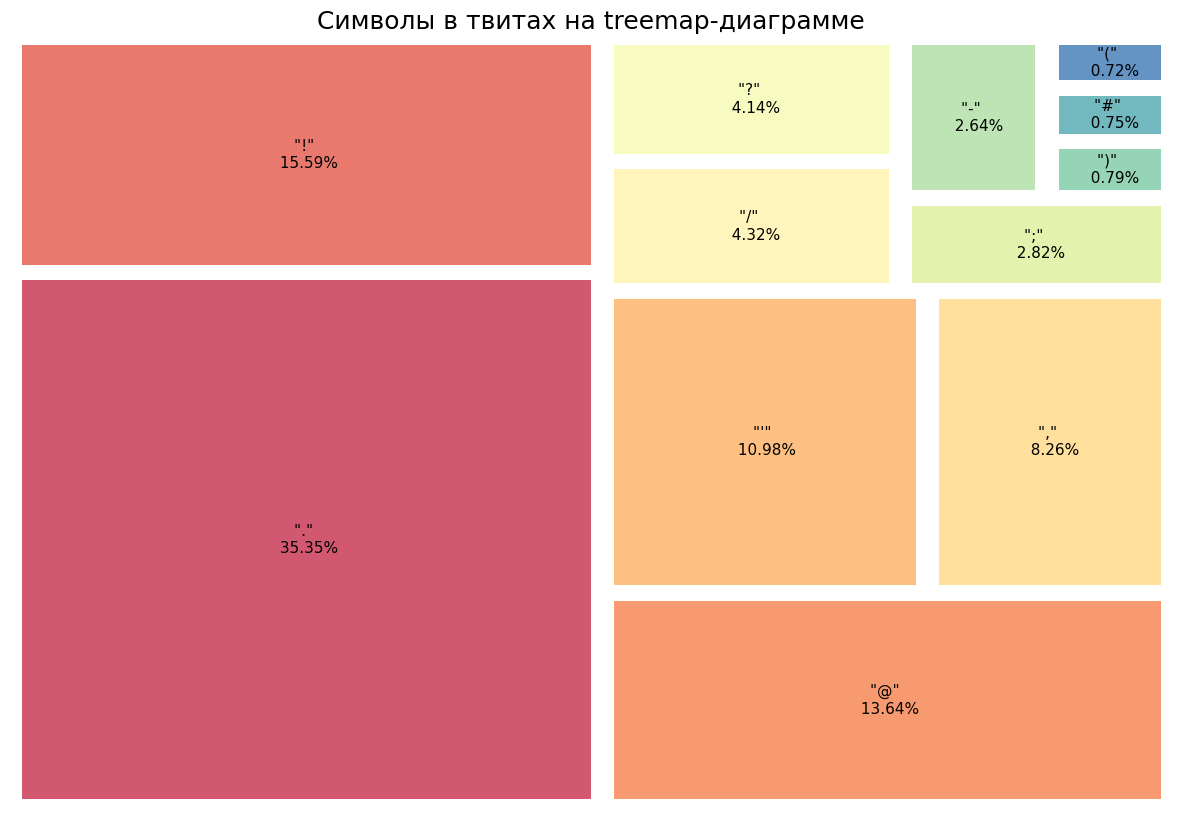

In [194]:
perc = [f'{i/sum(summary_all.values.tolist())*100:5.2f}%' for i in summary_all.values.tolist()]
lbl = [f'"{el[0]}" \n {el[1]}' for el in zip(labels, perc)]

plt.figure(figsize=(15, 10))
axis = squarify.plot(sizes=summary_all.values.tolist(), label=lbl, pad=1, alpha=0.8, color=sns.color_palette('Spectral',len(labels)), text_kwargs={'fontsize': 11})
axis.set_title('Символы в твитах на treemap-диаграмме', fontsize=18)
plt.axis('off')
plt.show()

Treemap-диаграмма отображает иерархические данные в виде набора вложенных друг в друга прямоугольников. Каждая группа представлена прямоугольником, площадь которого пропорциональна ее значению. Данная диаграмма позволяет нам наглядно понять, распределение количества символов во всех твитах датасета. Такие символы, как ".", "!" и "@" чаще всего встречаются в твитах.

In [88]:
#Количество знаков для каждой тональности
summary = df.groupby('feeling').agg({
    '._count': 'sum',
    '!_count': 'sum',
    '@_count': 'sum',
    "'_count": 'sum',
    ",_count": 'sum',
    '/_count': 'sum',
    '?_count': 'sum',
    ';_count': 'sum',
    '-_count': 'sum',
    ')_count': 'sum',
    '#_count': 'sum',
    '(_count': 'sum',
}).reset_index()
summary

,feeling,._count,!_count,@_count,'_count,",_count",/_count,?_count,;_count,-_count,)_count,#_count,(_count
0,0,107085,36342,30657,33240,21462,9054,11050,6526,6148,1854,1793,1912
1,1,89780,50496,45330,27925,24516,14985,12027,9205,8546,2567,2373,2077


In [89]:
summary = summary.rename(index={0:'Негативная', 1:'Позитивная'})
y0 = summary.loc['Негативная'][1:].tolist()
y1 = summary.loc['Позитивная'][1:].tolist()

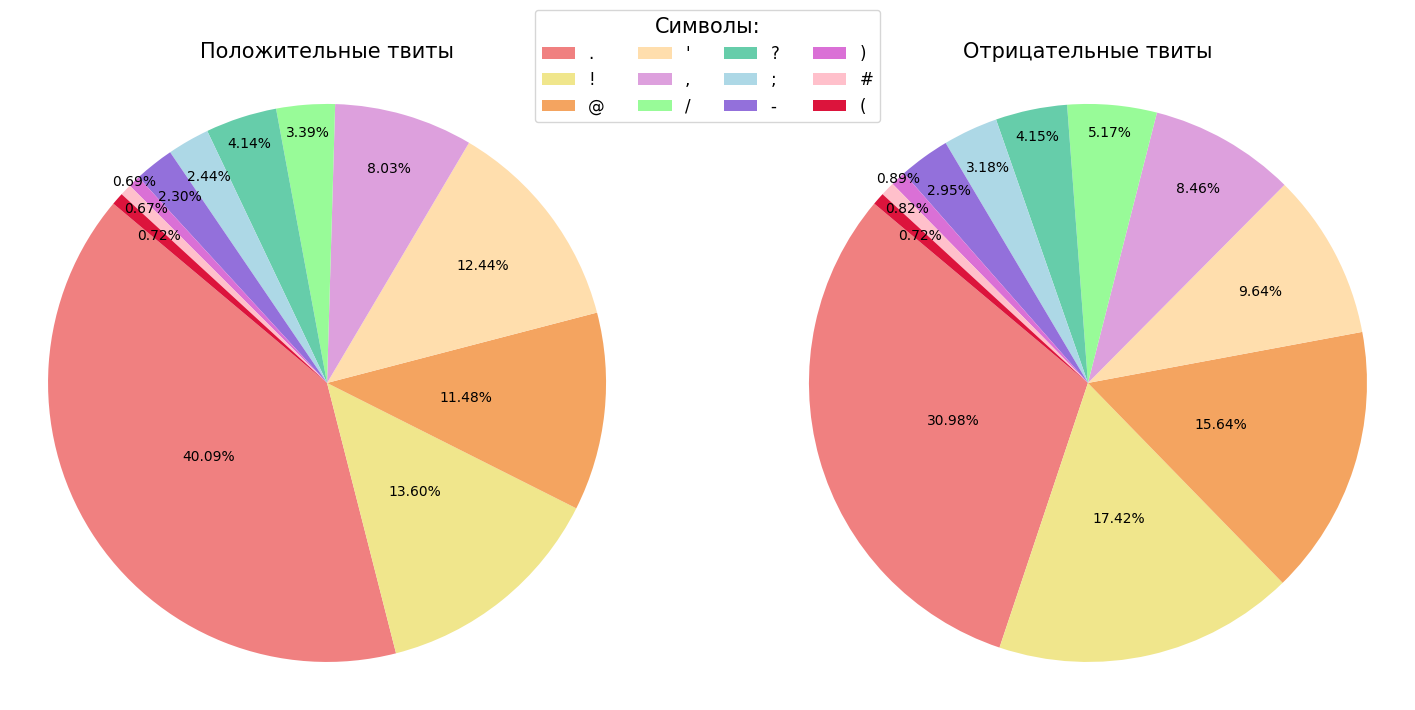

In [186]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))
w,l,p = ax1.pie(y0, colors=colors,
        autopct='%1.2f%%', startangle=140, pctdistance=1, radius = 1.1)
pctdists = [0.5, 0.5, 0.5, 0.7, 0.8, 0.9, 0.9, 0.85, 0.85, 1, 0.9, 0.8]
for t,d in zip(p, pctdists):
    xi,yi = t.get_position()
    ri = np.sqrt(xi**2+yi**2)
    phi = np.arctan2(yi,xi)
    x = d*ri*np.cos(phi)
    y = d*ri*np.sin(phi)
    t.set_position((x,y))
ax1.title.set_text('Положительные твиты')
ax1.title.set_size(15)


ax1.legend(labels=labels, title = 'Символы:', bbox_to_anchor=(1.1, 1), ncol=4, loc='center', fontsize=12, title_fontsize=15)

w,l,p = ax2.pie(y1, colors=colors,
        autopct='%1.2f%%', startangle=140, pctdistance=1, radius = 1.1)
pctdists = [0.5, 0.5, 0.5, 0.7, 0.8, 0.9, 0.9, 0.85, 0.85, 1, 0.9, 0.8]
for t,d in zip(p, pctdists):
    xi,yi = t.get_position()
    ri = np.sqrt(xi**2+yi**2)
    phi = np.arctan2(yi,xi)
    x = d*ri*np.cos(phi)
    y = d*ri*np.sin(phi)
    t.set_position((x,y))
ax2.title.set_text('Отрицательные твиты')
ax2.title.set_size(15)

plt.show()

На данных круговых диаграммах отображено пропорциональное соотношение символов к общему количеству символов в твитах по тональности. Общая картина одинакова, если сравнивать множества "положительных" и "отрицательных" сиволов в твитах. Тем не менее можно пронаблюдать, что среди "положительных" твитов соотношение таких сиволов, как "!'/" сильно меньше, чем среди "отрицательных" твитов.

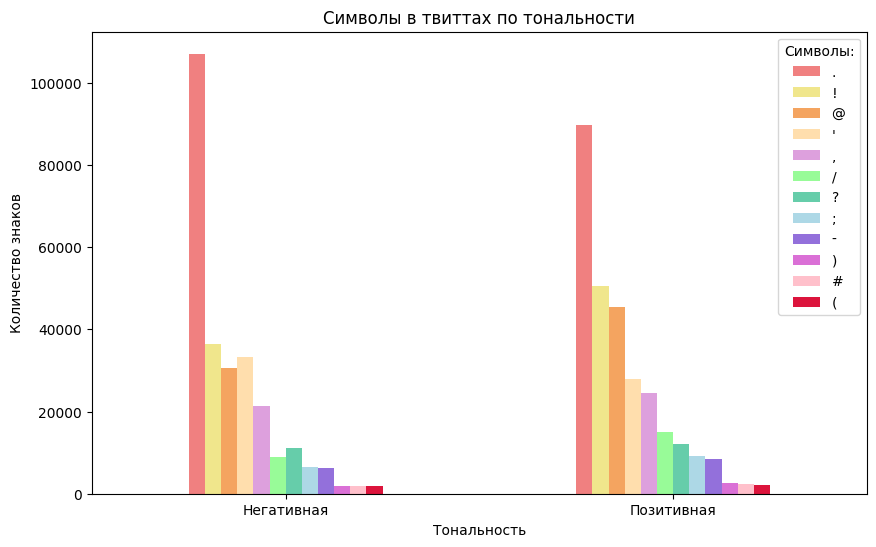

In [99]:
summary.drop('feeling', axis=1).plot(kind="bar", figsize=(10,6), rot=0, color=colors)
plt.title('Символы в твитах по тональности')
plt.legend(labels, title="Символы:")
plt.ylabel('Количество знаков')
plt.xlabel('Тональность')
plt.show()

При помощи столбчатых диаграмм можно пронаблюдать превоходство одних знаков над другими. На данном графике видно, что точек в твитах существенно больше, чем других сиволов, при этом их больше в негативных твитах, чем в позитивных. В позитивных твитах больше восклицательных знаков и символов @, которые в основном стоят перерд никнеймами. В отрицательных твитах больше апострофов и
точек.

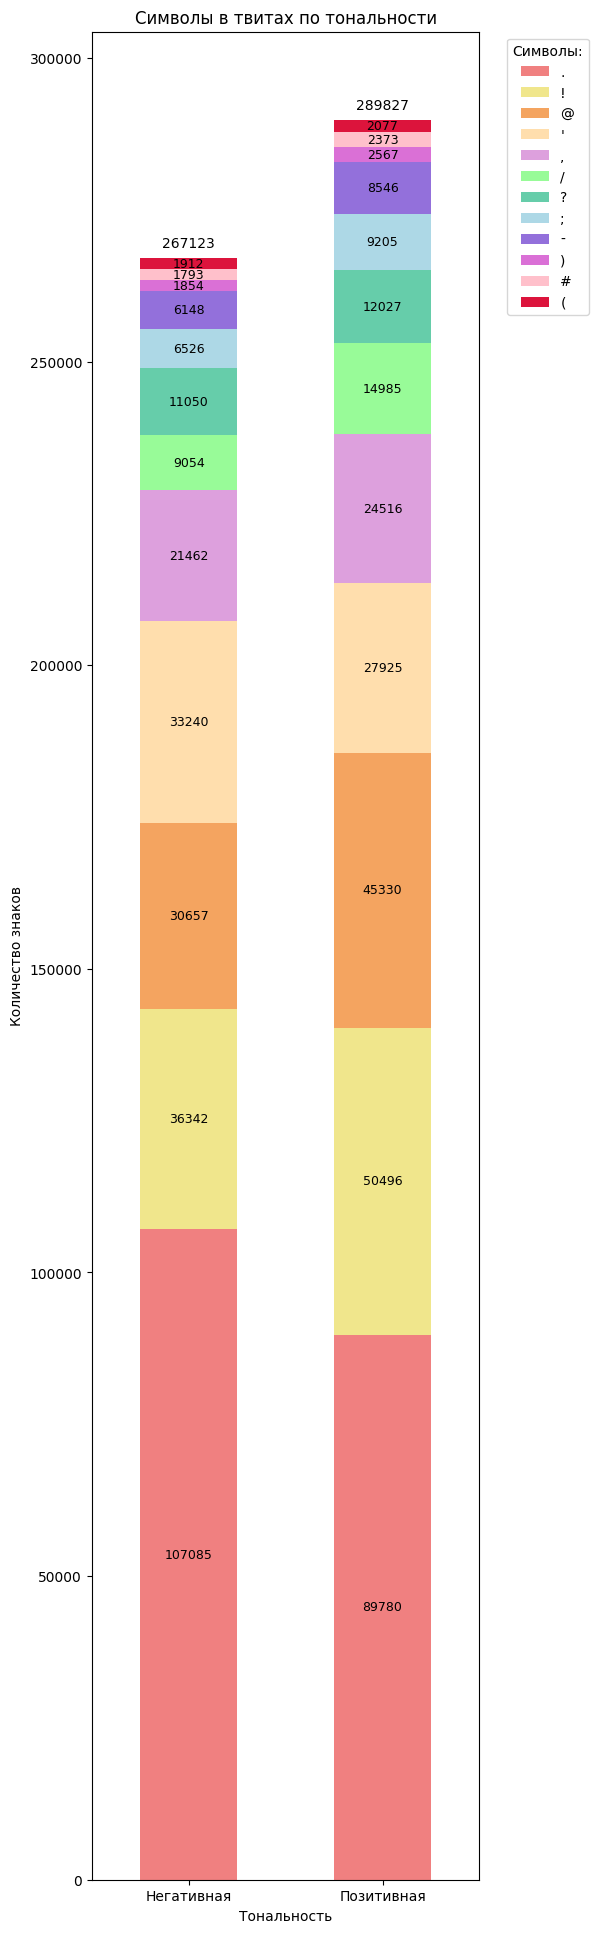

In [118]:
ax = summary.drop('feeling', axis=1).plot.bar(stacked=True, figsize=(5, 24), rot=0, color=colors)
for c in ax.containers:
    ax.bar_label(c, label_type='center', fontsize=9)
ax.bar_label(ax.containers[11], padding=5)
ax.legend(labels=labels, title='Символы:', bbox_to_anchor=(1.3, 1))
plt.title('Символы в твитах по тональности')
plt.ylabel('Количество знаков')
plt.xlabel('Тональность')
plt.show()

На этой линейчатой диаграмме с наколплением две колонки: для положительных и отрицательных твитов. Столбчатые диаграммы не отображают визуальную разницу в количестве для символов, которых значительно меньше по сравнению с другими элементами, например, точками. Линейчатая диаграмма с накоплением показывает, что количество символов '/', '?', ';', '-', ')', '#', '(' в различных тональностях примерно одинаково.

## **3.3. Предобработка текста**

**Этапы очистки данных от зашумлений:**
1. заменяем стандартные HTML-сущности на соответствующие символы. Примеры:
  *   & quot; --> "
  *   & amp; --> &
  *   & lt; --> <
  *   & gt; --> >
  *   & apos; или &#39; --> '
2. удаляем электронные адреса (например, *1234_world@abcde.lol*) и ведём статистику по ним
2. удаляем никнеймы (например, *@xxxx9010*) и ведём статистику по ним
3. удаляем ссылки на сайты в формате *www* и *http* и ведём статистику по ним
5. исследуем HTML-теги
6. исследуем хэштеги и ведём статистику по ним

In [ ]:
df.head()

,feeling,tweet,word_count,char_count
0,0,Starting back at work today Looks like it'l...,16,87
1,1,Sugar levels dropping... munchies setting in. ...,16,103
2,1,@karineb22 yeah!!! have a great summer break!,7,46
3,1,hannah montana was very good. now going to re...,10,59
4,1,"@Mayra326 aww, have fun! I just had my 3D las...",11,53


**3.3.1. Обработка HTML-cущностей**

In [ ]:
df['tweet'] = df['tweet'].apply(unescape)

In [ ]:
HTML_symbols_check = ['&quot;', '&amp;', '&lt', '&gt;', '&apos;', '&#39;'] #Проверяем, что HTML-cущности заменены на соответствующие символы

for symbol in HTML_symbols_check:
    if df['tweet'].str.contains(symbol).any():
        print(f"Символ '{symbol}' найден в датасете.")
    else:
        print(f"Символ '{symbol}' не найден в датасете.")

Символ '&quot;' не найден в датасете.
Символ '&amp;' не найден в датасете.
Символ '&lt' не найден в датасете.
Символ '&gt;' не найден в датасете.
Символ '&apos;' не найден в датасете.
Символ '&#39;' не найден в датасете.


**3.3.2. Обработка электронных адресов**

In [ ]:
emails = df['tweet'].str.findall(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}').sum()
emails_count = Counter(emails)

In [ ]:
df_emails_count = pd.DataFrame(emails_count.items(), columns=['email', 'count'])

In [ ]:
df_emails_count.head()

,email,count
0,gemma@illuminate-coaching.co.uk,1
1,rheckendo@yahoo.com,1
2,dzinn3@gmail.com,1
3,demilovato_mexican_fans@hotmail.com,1
4,hsnaa_040807@hotmail.com,1


In [ ]:
df_emails_count.sort_values(by='count', ascending=False).head() #Статистика по электронным адресам

,email,count
12,fuseboxradio@gmail.com,2
0,gemma@illuminate-coaching.co.uk,1
39,bzt@storebrand.no,1
29,jimbojose-jimbo@hotmail.com,1
30,andreita_princes_pink@hotmail.com,1


**3.3.3. Обработка никнеймов**

In [ ]:
nicknames = df['tweet'].str.findall(r'@([A-Za-z0-9_]{1,15})').sum()
nicknames_count = Counter(nicknames)

In [ ]:
df_nicks_count = pd.DataFrame(nicknames_count.items(), columns=['nickname', 'count'])

In [ ]:
df_nicks_count

,nickname,count
0,karineb22,1
1,Mayra326,1
2,asherroth,3
3,sunday67,1
4,DavidBedwell,1
...,...,...
57221,krikitmedia,1
57222,strmofconscious,1
57223,seanhfitz,1
57224,4,1


In [ ]:
df_nicks_count.sort_values(by='count', ascending=False).head() #Cтатистика по никам

,nickname,count
252,mileycyrus,382
193,tommcfly,347
237,ddlovato,310
19,Jonasbrothers,119
49,DonnieWahlberg,117


**3.3.4. Обработка ссылок**

In [ ]:
urls = df['tweet'].str.findall(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})').sum()
urls_count = Counter(urls)

In [ ]:
df_urls_count = pd.DataFrame(urls_count.items(), columns=['url', 'count'])

In [ ]:
df_urls_count

,url,count
0,http://www.myspace.com/poloclub,1
1,http://plurk.com/p/vh7db,1
2,http://tinyurl.com/csclps,1
3,http://twitpic.com/794aw,2
4,http://is.gd/JjUQ,1
...,...,...
6521,http://tumblr.com/x6y1mmpel,1
6522,http://bit.ly/Px2ne,1
6523,http://bit.ly/IULNA,1
6524,http://tinyurl.com/o9dwbf,1


In [ ]:
df_urls_count.sort_values(by='count', ascending=False).head() #Статистика по ссылкам

,url,count
110,www.tweeteradder.com,72
161,http://tweet.sg,70
261,www.tweeterfollow.com,56
553,www.iamsoannoyed.com,20
70,www.m2e.asia,15


**3.3.5. Обработка HTML-тегов**

In [ ]:
htmls = df['tweet'].str.findall(r'<[^>]+>').sum()
htmls_count = Counter(htmls)

In [ ]:
df_htmls_count = pd.DataFrame(htmls_count.items(), columns=['html', 'count'])

In [ ]:
df_htmls_count

,html,count
0,< monica>,3
1,<b>,1
2,<.< >,1
3,<T>,1
4,<quick..blame him for sumpin>,1
...,...,...
86,<Fob is my life<3>,1
87,<batedbreath>,1
88,<dusting self off>,1
89,<looking both weys>,1


In [ ]:
df_htmls_count.sort_values(by='count', ascending=False).head() #Статистика по HTML-символам

,html,count
0,< monica>,3
6,"<Que sera, sera!>",2
43,<sigh>,2
18,<3AaRoN-->,2
11,<hug>,2


Несмотря на то что мы видим 91 строку, в которых присутствуют символы < и >, к HTML-тегам относятся только следующие строки: < /a >, < b >, < div >, < em > и < /em >. Мы не будем очищать от них данные, поскольку их очень мало. Указанные знаки будут рассматриваться в качестве шума.

**3.3.6. Обработка хэштегов**

In [ ]:
hashtags = df['tweet'].str.findall(r'#\w+').sum()
hashtags_count = Counter(hashtags)

In [ ]:
df_hashtags_count = pd.DataFrame(hashtags_count.items(), columns=['hashtag', 'count'])

In [ ]:
df_hashtags_count

,hashtag,count
0,#SXSEMIA,1
1,#squarespace,95
2,#ACBF,1
3,#KariDosai,1
4,#FF,53
...,...,...
2111,#Confessions,1
2112,#of,1
2113,#a,1
2114,#corporate,1


In [ ]:
df_hashtags_count.sort_values(by='count', ascending=False).head() #Статистика по hashtags

,hashtag,count
13,#followfriday,198
46,#fb,184
1,#squarespace,95
4,#FF,53
220,#1,50


**3.3.7. Итоговая обработка элементов**

Создадим столбцы, которые будут отражать количество вхождений электронной почты, никнейма, ссылки и хэштега в каждом твите:
* 1 - элемент в твите есть,
* 0 - иначе.




In [ ]:
#Функции для подсчета количества элементов в твите
def count_emails(tweet):
    return len(re.findall(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', tweet))

def count_nicknames(tweet):
    return len(re.findall(r'@([A-Za-z0-9_]{1,})', tweet))

def count_urls(tweet):
    return len(re.findall(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', tweet))

def count_hashtags(tweet):
    return len(re.findall(r'#\w+', tweet))

In [ ]:
df['email_count'] = df['tweet'].apply(count_emails)
df['nickname_count'] = df['tweet'].apply(count_nicknames)
df['url_count'] = df['tweet'].apply(count_urls)
df['hashtag_count'] = df['tweet'].apply(count_hashtags)

In [ ]:
df.sample(10)

,feeling,tweet,word_count,char_count,email_count,nickname_count,url_count,hashtag_count
149467,1,why is it that jason mraz's songs can always p...,15,69,0,0,0,0
23254,0,So slow at work. I can't wait to see the tatt...,16,77,0,0,0,0
3168,1,lovely day at navy pier,5,24,0,0,0,0
100716,0,Can't find my fuccin headphones.... Smh @ me !...,14,80,0,0,0,0
23491,0,"@pandafandanga werd. I miss him. Hell man, I m...",14,80,0,1,0,0
95642,0,@SaraDonmoyer omg such an INTENSE episode! can...,22,127,0,1,0,0
36036,1,@LeviBeamishthey sent me 3 double passes,6,41,0,1,0,0
41039,1,"@YourWxToday Yea, it was a bummer it was raine...",27,142,0,1,0,0
126210,0,"@sherisaid I'm so sorry, sweetie. It's so har...",18,111,0,1,0,0
144501,1,@luciendesar Thank you,3,24,0,1,0,0


In [ ]:
#Количество элементов по тональности
group_email = df.groupby('feeling')['email_count'].sum()
group_nickname = df.groupby('feeling')['nickname_count'].sum()
group_url = df.groupby('feeling')['url_count'].sum()
group_hashtag = df.groupby('feeling')['hashtag_count'].sum()

In [ ]:
elements = {
    'электронных адресов': group_email,
    'никнеймов': group_nickname,
    'URL-адресов': group_url,
    'хэштегов': group_hashtag
}

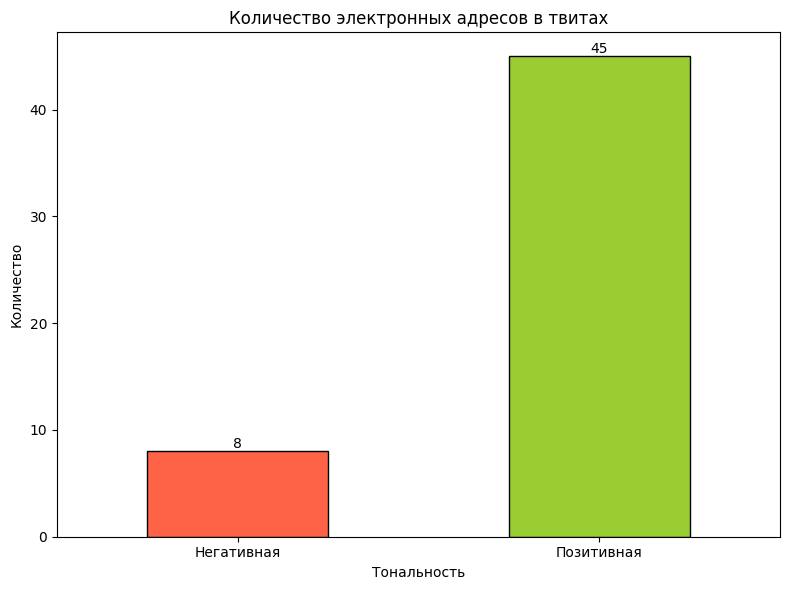

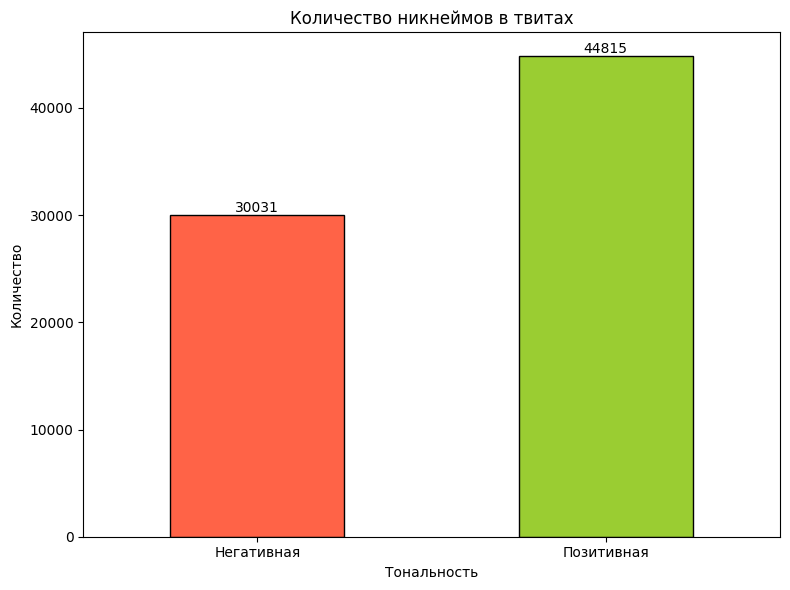

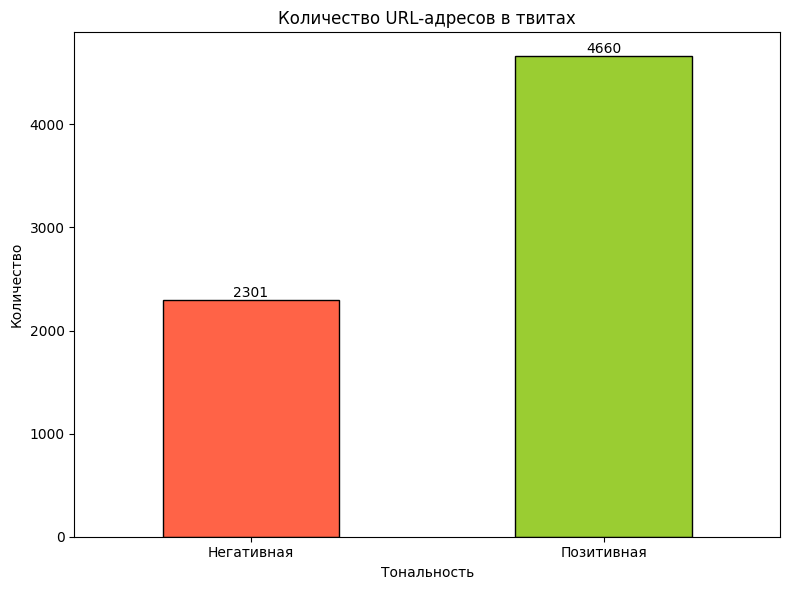

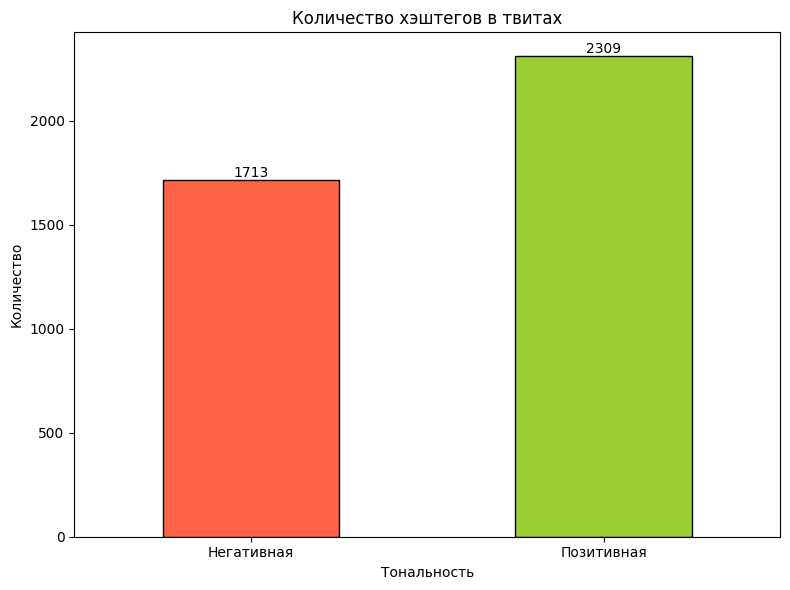

In [ ]:
for element, counts in elements.items():
    plt.figure(figsize=(8, 6))
    counts.plot(kind='bar', color=['tomato', 'yellowgreen'], edgecolor='black')
    plt.title(f'Количество {element} в твитах')
    plt.xlabel('Тональность')
    plt.ylabel('Количество')
    plt.xticks(ticks=[0, 1], labels=['Негативная', 'Позитивная'], rotation=0)

    for index, value in enumerate(counts):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Количество электронных адресов, никнеймов, ссылок на различные сайты и хэштегов гораздо больше в твитах положительной тональности. Вероятно, люди, испытывающие положительные эмоции, хотят как можно большему числу людей рассказть о своём позитивном опыте, достижении и т. д. Например, человек, довольный покупкой товара, может поделиться ссылкой на него с другими. Он может отметить человека, с которым получил классный опыт, использовать хэштег для привлечения внимания к теме или оставить электронный адрес компании, к которой можно обратиться, чтобы получить нужную услугу и т. д.

Негативным опытом готов делиться далеко не каждый человек. Человек может просто не хотеть множить негатив в социальной сети, опасаться осуждения, непонимания, нежелательных последствий, испортить репутацию (например, свою и компании, где человек занимает высокую должность, например) или человеку вовсе может быть стыдно публично рассказать о своём неудачном опыте.

Удаляем все найденные шумы:

In [ ]:
df['tweet'] = df['tweet'].str.replace(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', regex=True) #Удаляем emails
df['tweet'] = df['tweet'].str.replace(r'@([A-Za-z0-9_]{1,})', '', regex=True) #Удаляем ники
df['tweet'] = df['tweet'].str.replace(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', '', regex=True) #Удаляем urls

Как у же говорилось, HTML-теги мы не удаляем.
Хэштеги также оставляем, поскольку они помогают понять отношение людей к определённой теме.

Приводим твиты к нижнему регистру и удаляем в них все "небуквы":

In [ ]:
df['tweet'] = df['tweet'].str.lower()

In [ ]:
df['cleaned_tweet'] = df['tweet'].str.replace(r'[^a-zA-Z\s]', '', regex=True) #Удаляем знаки препинания и цифры и оставляем только буквы и пробелы

In [ ]:
df['cleaned_tweet'] = df['cleaned_tweet'].str.replace(r'\s+', ' ', regex=True).str.strip()  #Удаляем лишние пробелы

## **3.4. Общий анализ текстовых данных**

**3.4.1. Распределение количества слов и символов в твитах по всей выборке**

In [ ]:
df['word_count_cleaned'] = df['cleaned_tweet'].str.split().str.len() #Количество слов в твитах

In [ ]:
df['char_count_cleaned'] = df['cleaned_tweet'].str.len() #Количество символов в твитах

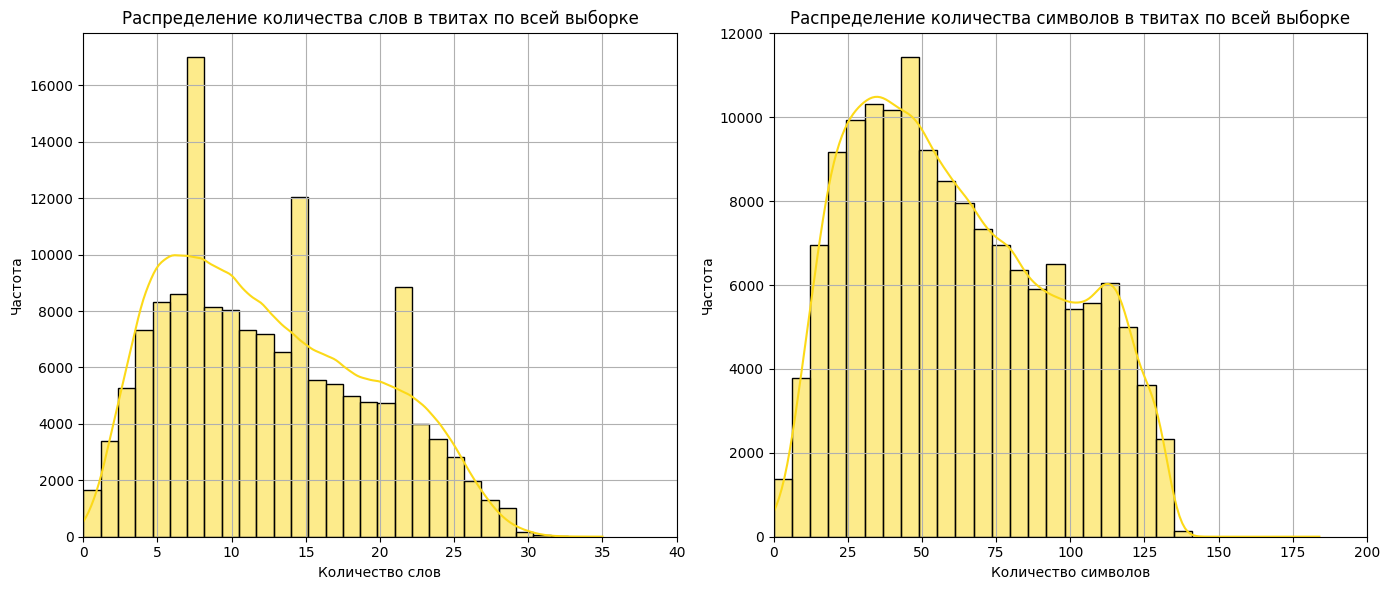

In [ ]:
#График распределения количества слов в твитах
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['word_count_cleaned'], bins=30, color='#fcd918', kde=True)
plt.title('Распределение количества слов в твитах по всей выборке')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.xlim(0, 40)
plt.grid()

#График распределения количества символов в твитах
plt.subplot(1, 2, 2)
sns.histplot(df['char_count_cleaned'], bins=30, color='#fcd918', kde=True)
plt.title('Распределение количества символов в твитах по всей выборке')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.xlim(0, 200)
plt.grid()

plt.tight_layout()
plt.show()

После обработки текста количество слов и символов в твитах снизилось примерно на 5 и 35 соответственно: теперь длина твитов чаще всего не превышает 30-32 слов, или 140 символов. Длина твитов не превосходит 35 слов, или 175 символов. Наиболее распространённая длина одного твита - 8, 15 и 15 слова (18-75 символов).
Данные результат ожидаем, поскольку мы убрали из твитов электронные адреса,никнеймы, ссылки, отдельно стоящие символы и пр., что, очевидно, увеличивало длину твитов.

**3.4.2. Распределение количества слов и символов в твитах позитивной выборки**

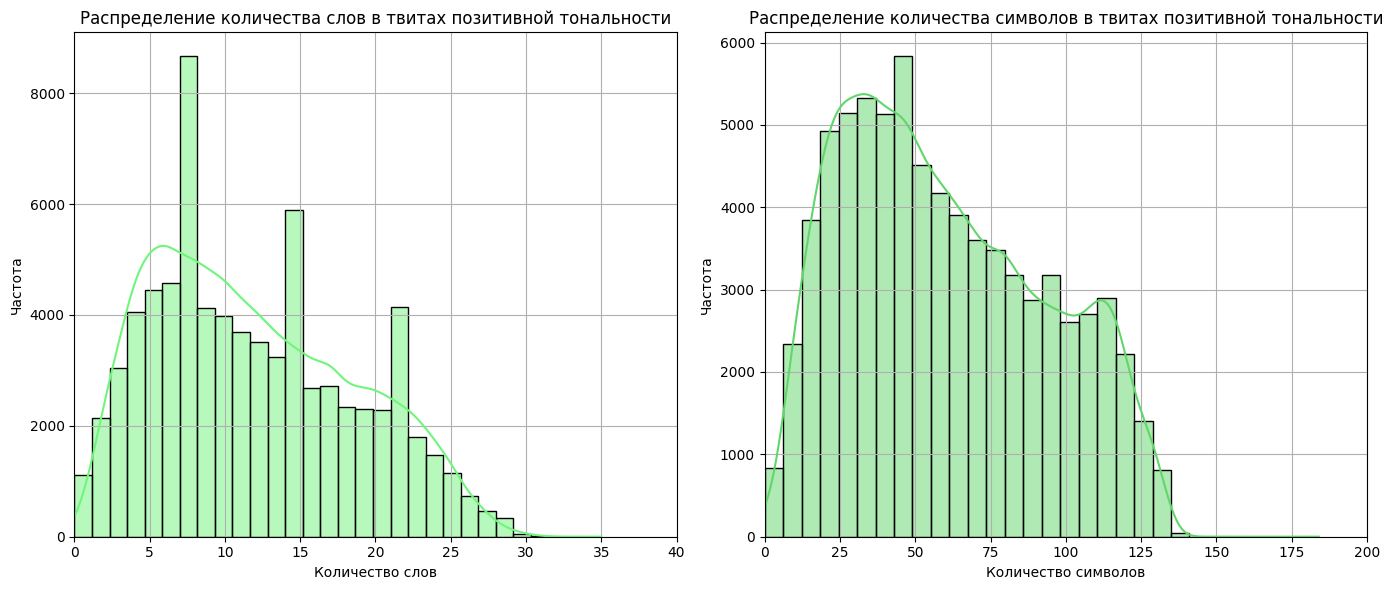

In [ ]:
#График распределения количества слов в твитах
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[df['feeling'] == 1]['word_count_cleaned'], bins=30, color='#70f57c', kde=True)
plt.title('Распределение количества слов в твитах позитивной тональности')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.xlim(0, 40)
plt.grid()

#График распределения количества символов в твитах
plt.subplot(1, 2, 2)
sns.histplot(df[df['feeling'] == 1]['char_count_cleaned'], bins=30, color='#61d66b', kde=True)
plt.title('Распределение количества символов в твитах позитивной тональности')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.xlim(0, 200)
plt.grid()

plt.tight_layout()
plt.show()

Выводы для твитов положительной тональности аналогичны общим выводам:
*  чаще всего длина твитов положительной тональности не превосходит 32 слов, или 140 символов;
* наиболее распространённая длина одного твита - 7, 15, 22 слов (18-80 символов).

**3.4.3. Распределение количества слов и символов в твитах позитивной выборки**

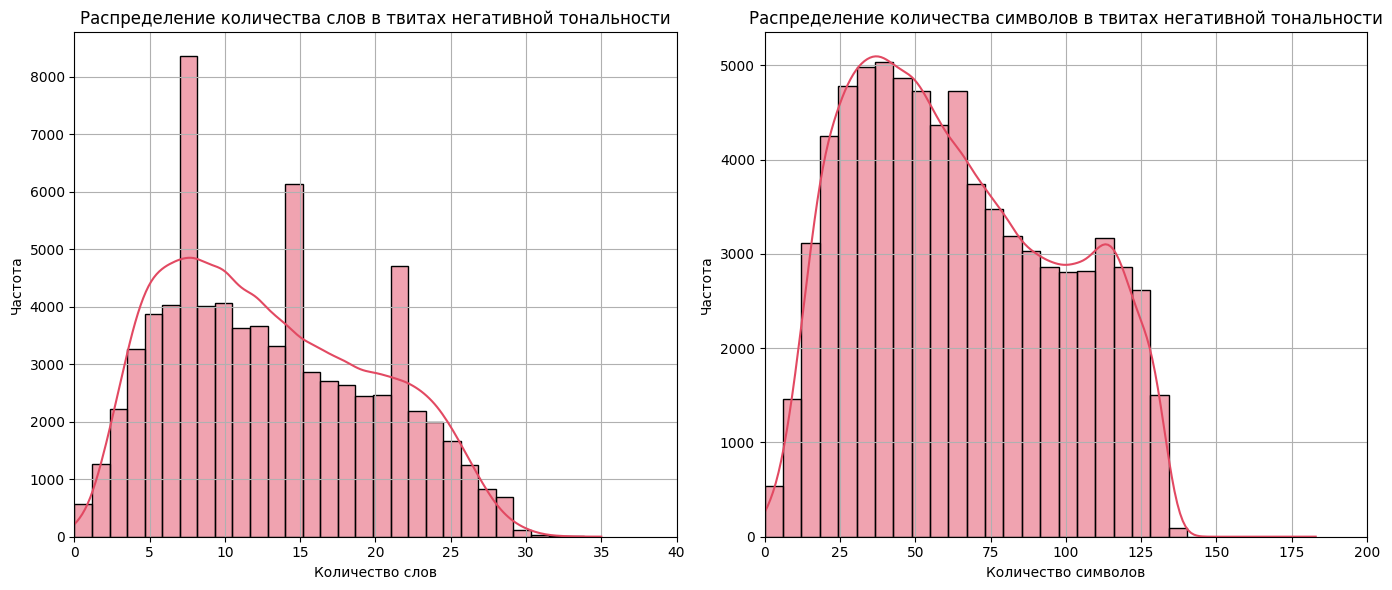

In [ ]:
#График распределения количества слов в твитах
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df[df['feeling'] == 0]['word_count_cleaned'], bins=30, color='#e24962', kde=True)
plt.title('Распределение количества слов в твитах негативной тональности')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.xlim(0, 40)
plt.grid()

#График распределения количества символов в твитах
plt.subplot(1, 2, 2)
sns.histplot(df[df['feeling'] == 0]['char_count_cleaned'], bins=30, color='#e24962', kde=True)
plt.title('Распределение количества символов в твитах негативной тональности')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.xlim(0, 200)
plt.grid()

plt.tight_layout()
plt.show()

Количество слов твитов отрицательной тональности не превосходит 32, а количество символов - 140, что характерно и для общей выборки, и для позитивных твитов отдельно.
Наиболее часто негативные твиты имеют длину 8, 15 и 22 слова (20-80 символов).

**3.4.4. Распределение минимальной, средней и максимальной длины твитов по всей выборке**

In [ ]:
df

,feeling,tweet,word_count,char_count,email_count,nickname_count,url_count,hashtag_count,cleaned_tweet,word_count_cleaned,char_count_cleaned
0,0,starting back at work today looks like it'l...,16,87,0,0,0,0,starting back at work today looks like itll be...,16,82
1,1,sugar levels dropping... munchies setting in. ...,16,103,0,0,0,0,sugar levels dropping munchies setting in luck...,16,98
2,1,yeah!!! have a great summer break!,7,46,0,1,0,0,yeah have a great summer break,6,30
3,1,hannah montana was very good. now going to re...,10,59,0,0,0,0,hannah montana was very good now going to read...,10,55
4,1,"aww, have fun! i just had my 3d last week!",11,53,0,1,0,0,aww have fun i just had my d last week,10,38
...,...,...,...,...,...,...,...,...,...,...,...
149980,0,had a great night at tabs but now i'm missing ...,14,65,0,0,0,0,had a great night at tabs but now im missing c...,14,62
149981,1,what a night at work.. church in the morning,9,45,0,0,0,0,what a night at work church in the morning,9,42
149982,0,this book is terrible im used 2 reading all ...,25,137,0,0,0,0,this book is terrible im used reading all make...,24,131
149983,0,"updates? any? i miss your updates, guys!",8,57,0,1,0,0,updates any i miss your updates guys,7,36


In [ ]:
df_char_count_cleaned = pd.DataFrame({
    'char_count_cleaned': df['char_count_cleaned'],
    'char_count_cleaned_neg': df[df['feeling'] == 0]['char_count_cleaned'].reset_index(drop=True),
    'char_count_cleaned_pos': df[df['feeling'] == 1]['char_count_cleaned'].reset_index(drop=True)
})

In [ ]:
df_char_count_cleaned.describe()

,char_count_cleaned,char_count_cleaned_neg,char_count_cleaned_pos
count,149985.000000,75019.000000,74966.000000
mean,62.083635,64.235447,59.930302
std,33.593544,33.847722,33.198140
min,0.000000,0.000000,0.000000
25%,34.000000,36.000000,32.000000
50%,57.000000,60.000000,55.000000
75%,89.000000,91.000000,86.000000
max,184.000000,183.000000,184.000000


In [ ]:
descriptive_stats_cleaned = df_char_count_cleaned.describe().loc[['min', 'mean', 'max']].values.T

In [ ]:
descriptive_stats_cleaned

array([[  0.        ,  62.08363503, 184.        ],
       [  0.        ,  64.23544702, 183.        ],
       [  0.        ,  59.93030174, 184.        ]])

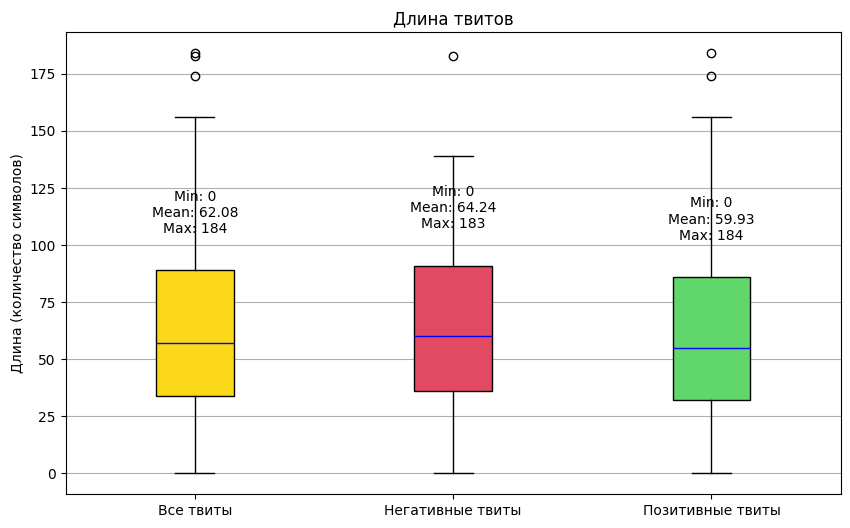

In [ ]:
#Данные для boxplot'ов
data = [df['char_count_cleaned'], df[df['feeling'] == 0]['char_count_cleaned'], df[df['feeling'] == 1]['char_count_cleaned']]

plt.figure(figsize=(10, 6))
bplot = plt.boxplot(data,
                    labels=['Все твиты', 'Негативные твиты', 'Позитивные твиты'],
                    vert=True,
                    patch_artist=True)

#Цвета для ящиков с усами
bplot['boxes'][0].set_facecolor('#fcd918')
bplot['boxes'][1].set_facecolor('#e24962')
bplot['boxes'][2].set_facecolor('#61d66b')

#Цвет медианы
for median in bplot['medians']:
    median.set_color('blue')

for i, box in enumerate(bplot['boxes']):
    bbox = box.get_path().get_extents()
    x = bbox.x0 + (bbox.x1 - bbox.x0) / 2
    y = bbox.y1 + 15
    plt.text(x, y, f"Min: {descriptive_stats_cleaned[i,0]:.0f}\nMean: {descriptive_stats_cleaned[i,1]:.2f}\nMax: {descriptive_stats_cleaned[i,2]:.0f}", ha='center', va='bottom')


plt.title('Длина твитов')
plt.ylabel('Длина (количество символов)')
plt.grid(axis='y')
plt.show()

После обработки текста минимальное количество символов - 0 - совпадает для позитивных и негативных твитов.
Средняя длина твитов положительной и отрицательной тональностей стала различаться на 4,31 символа в пользу негативных твитов. Средняя длина позитинвых твитов составляет 59,93 символа, средняя длина негативных твитов - 64,24 символа. При этом максимальная длина позитивных твитов  превосходит максимальную длину негативных твитов на 1 символ - 184 против 183 символов.
Длина 75% наблюдений позитивных твитов меньше 86 символов, а длина негативных твитов - 91 символов, что на 17 и 14 меньше длины необработанных твитов положительной и отрицательной тональностей соответственно.

Таким образом, длина твитов отрицательной тональности превышает длину твитов положительной тональности. Это можно объяснить тем, что люди, испытывающие негативные эмоции, склонны делиться своими мыслями более подробно с собеседниками, ожидая получить ответную реакцию. При этом, как мы выяснили, ссылки, хэштеги и пр. в случае негативных твитах они используют меньше, чем люди, готовые делиться положительными эмоциями.

На данном этапе датасет выглядит следующим обазом:

In [ ]:
df.head()

,feeling,tweet,word_count,char_count,email_count,nickname_count,url_count,hashtag_count,cleaned_tweet,word_count_cleaned,char_count_cleaned
0,0,starting back at work today looks like it'l...,16,87,0,0,0,0,starting back at work today looks like itll be...,16,82
1,1,sugar levels dropping... munchies setting in. ...,16,103,0,0,0,0,sugar levels dropping munchies setting in luck...,16,98
2,1,yeah!!! have a great summer break!,7,46,0,1,0,0,yeah have a great summer break,6,30
3,1,hannah montana was very good. now going to re...,10,59,0,0,0,0,hannah montana was very good now going to read...,10,55
4,1,"aww, have fun! i just had my 3d last week!",11,53,0,1,0,0,aww have fun i just had my d last week,10,38


# **4) Обработка текста**

В главе 4
1.  проводится токенизация текста по словам -- каждый твит рабивается на токены (слова);
2.  удаляются стоп-слова - слова, которые не несут большой смысловой нагрузки, но зашумляют данные. К таким словам относятся союзы, междометия, артикли и др.;
3.  рассматривается количество слов различных частей речи в твитах. Для наглядности строится горизонтальная столбчатая диаграмма (bar);
4.  проводится лемматизация -- приведение каждого слова к канонической форме (лемме);
5. анализируются облака слов и топ-20 слов твитов позитивной и негативной тональностей;
6. строятся би- и триграммы для твитов обоих типов тональности.


### **4.1. Токенизация**

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['tokens'] = df['cleaned_tweet'].apply(word_tokenize)

In [ ]:
df['tokens']

,tokens
0,"[starting, back, at, work, today, looks, like,..."
1,"[sugar, levels, dropping, munchies, setting, i..."
2,"[yeah, have, a, great, summer, break]"
3,"[hannah, montana, was, very, good, now, going,..."
4,"[aww, have, fun, i, just, had, my, d, last, week]"
...,...
149980,"[had, a, great, night, at, tabs, but, now, im,..."
149981,"[what, a, night, at, work, church, in, the, mo..."
149982,"[this, book, is, terrible, im, used, reading, ..."
149983,"[updates, any, i, miss, your, updates, guys]"


### **4.2. Удаление стоп-слов**

In [ ]:
def delete_stopwords(tokens):
    cleaned = []
    for word in tokens:
        if word not in stop_words:
            cleaned.append(word)
    return cleaned

df['cleaned_tokens'] = df['tokens'].apply(delete_stopwords)

In [ ]:
df['cleaned_tokens']

,cleaned_tokens
0,"[starting, back, work, today, looks, like, itl..."
1,"[sugar, levels, dropping, munchies, setting, l..."
2,"[yeah, great, summer, break]"
3,"[hannah, montana, good, going, read, twilight]"
4,"[aww, fun, last, week]"
...,...
149980,"[great, night, tabs, im, missing, chad, going,..."
149981,"[night, work, church, morning]"
149982,"[book, terrible, im, used, reading, make, beli..."
149983,"[updates, miss, updates, guys]"


### **4.3. Лемматизация**

In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def lemmatize_tokens(tokens):
    lemmatized = []
    for word in tokens:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

df['lemmatized'] = df['cleaned_tokens'].apply(lemmatize_tokens)

In [ ]:
df.head()

,feeling,tweet,word_count,char_count,email_count,nickname_count,url_count,hashtag_count,cleaned_tweet,word_count_cleaned,char_count_cleaned,tokens,cleaned_tokens,lemmatized
0,0,starting back at work today looks like it'l...,16,87,0,0,0,0,starting back at work today looks like itll be...,16,82,"[starting, back, at, work, today, looks, like,...","[starting, back, work, today, looks, like, itl...","[starting, back, work, today, look, like, itll..."
1,1,sugar levels dropping... munchies setting in. ...,16,103,0,0,0,0,sugar levels dropping munchies setting in luck...,16,98,"[sugar, levels, dropping, munchies, setting, i...","[sugar, levels, dropping, munchies, setting, l...","[sugar, level, dropping, munchies, setting, lu..."
2,1,yeah!!! have a great summer break!,7,46,0,1,0,0,yeah have a great summer break,6,30,"[yeah, have, a, great, summer, break]","[yeah, great, summer, break]","[yeah, great, summer, break]"
3,1,hannah montana was very good. now going to re...,10,59,0,0,0,0,hannah montana was very good now going to read...,10,55,"[hannah, montana, was, very, good, now, going,...","[hannah, montana, good, going, read, twilight]","[hannah, montana, good, going, read, twilight]"
4,1,"aww, have fun! i just had my 3d last week!",11,53,0,1,0,0,aww have fun i just had my d last week,10,38,"[aww, have, fun, i, just, had, my, d, last, week]","[aww, fun, last, week]","[aww, fun, last, week]"


### **4.4. Распределение частей речи**

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
df['pos_tags'] = df['lemmatized'].apply(pos_tag)

In [ ]:
df['pos_tags']

,pos_tags
0,"[(starting, VBG), (back, RP), (work, NN), (tod..."
1,"[(sugar, NN), (level, NN), (dropping, VBG), (m..."
2,"[(yeah, RB), (great, JJ), (summer, NN), (break..."
3,"[(hannah, NN), (montana, NN), (good, JJ), (goi..."
4,"[(aww, NN), (fun, NN), (last, JJ), (week, NN)]"
...,...
149980,"[(great, JJ), (night, NN), (tab, NN), (im, NN)..."
149981,"[(night, NN), (work, NN), (church, NN), (morni..."
149982,"[(book, NN), (terrible, JJ), (im, NN), (used, ..."
149983,"[(update, JJ), (miss, NN), (update, NN), (guy,..."


In [ ]:
df.head()

,feeling,tweet,word_count,char_count,email_count,nickname_count,url_count,hashtag_count,cleaned_tweet,word_count_cleaned,char_count_cleaned,tokens,cleaned_tokens,lemmatized,pos_tags
0,0,starting back at work today looks like it'l...,16,87,0,0,0,0,starting back at work today looks like itll be...,16,82,"[starting, back, at, work, today, looks, like,...","[starting, back, work, today, looks, like, itl...","[starting, back, work, today, look, like, itll...","[(starting, VBG), (back, RP), (work, NN), (tod..."
1,1,sugar levels dropping... munchies setting in. ...,16,103,0,0,0,0,sugar levels dropping munchies setting in luck...,16,98,"[sugar, levels, dropping, munchies, setting, i...","[sugar, levels, dropping, munchies, setting, l...","[sugar, level, dropping, munchies, setting, lu...","[(sugar, NN), (level, NN), (dropping, VBG), (m..."
2,1,yeah!!! have a great summer break!,7,46,0,1,0,0,yeah have a great summer break,6,30,"[yeah, have, a, great, summer, break]","[yeah, great, summer, break]","[yeah, great, summer, break]","[(yeah, RB), (great, JJ), (summer, NN), (break..."
3,1,hannah montana was very good. now going to re...,10,59,0,0,0,0,hannah montana was very good now going to read...,10,55,"[hannah, montana, was, very, good, now, going,...","[hannah, montana, good, going, read, twilight]","[hannah, montana, good, going, read, twilight]","[(hannah, NN), (montana, NN), (good, JJ), (goi..."
4,1,"aww, have fun! i just had my 3d last week!",11,53,0,1,0,0,aww have fun i just had my d last week,10,38,"[aww, have, fun, i, just, had, my, d, last, week]","[aww, fun, last, week]","[aww, fun, last, week]","[(aww, NN), (fun, NN), (last, JJ), (week, NN)]"


**4.4.1. Распределение частей речи по всей выборке**

In [ ]:
pos_counts = Counter()
for tags in df['pos_tags']:
    pos_counts.update(tag for word, tag in tags)

In [ ]:
df_pos = pd.DataFrame(pos_counts.items(), columns=['Part of Speech', 'Count'])

In [ ]:
df_pos

,Part of Speech,Count
0,VBG,54242
1,RP,1149
2,NN,504748
3,VBP,42751
4,IN,20077
5,JJ,192609
6,NNS,32640
7,RB,76543
8,VBD,43386
9,PRP,1449


In [ ]:
df_pos = df_pos.sort_values(by='Count', ascending=False).head(20)

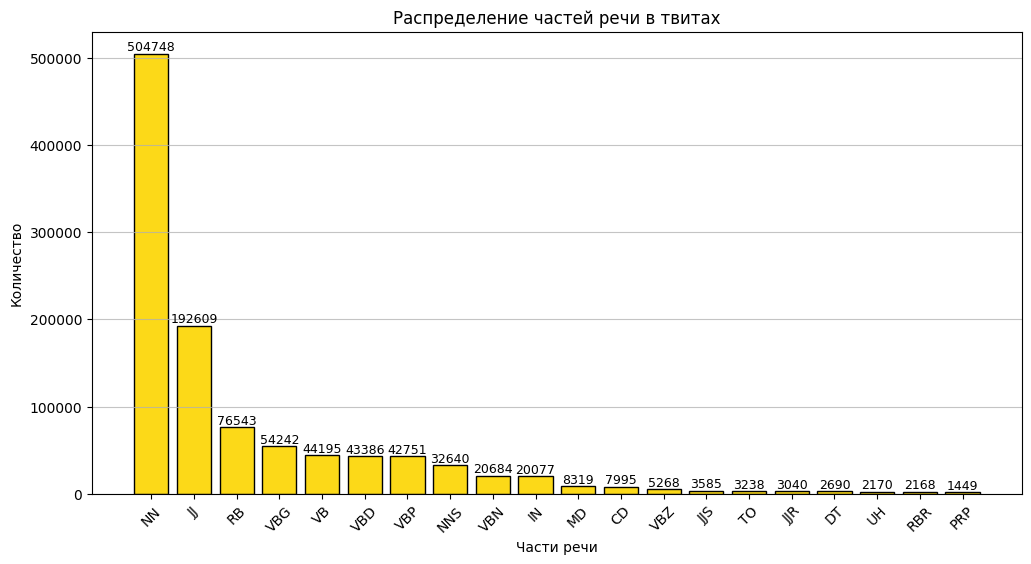

In [ ]:
plt.figure(figsize=(12, 6))
bars = plt.bar(df_pos['Part of Speech'], df_pos['Count'], color='#fcd918', edgecolor='black')
plt.title('Распределение частей речи в твитах')
plt.xlabel('Части речи')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             str(height), ha='center', va='bottom', fontsize=9)

plt.show()

**4.4.1. Распределение частей речи в позитивных твитах**

In [ ]:
df_pos = df[df['feeling'] == 1]

In [ ]:
pos_counts_pos = Counter()
for tags in df_pos['pos_tags']:
    pos_counts_pos.update(tag for word, tag in tags)

In [ ]:
df_pos_positive = pd.DataFrame(pos_counts_pos.items(), columns=['Part of Speech', 'Count'])

In [ ]:
df_pos_positive

,Part of Speech,Count
0,NN,246003
1,VBG,26438
2,NNS,18076
3,RB,35622
4,JJ,93556
5,CD,3952
6,VBD,18350
7,VB,21729
8,MD,3881
9,VBN,8741


In [ ]:
df_pos_positive = df_pos_positive.sort_values(by='Count', ascending=False).head(20)

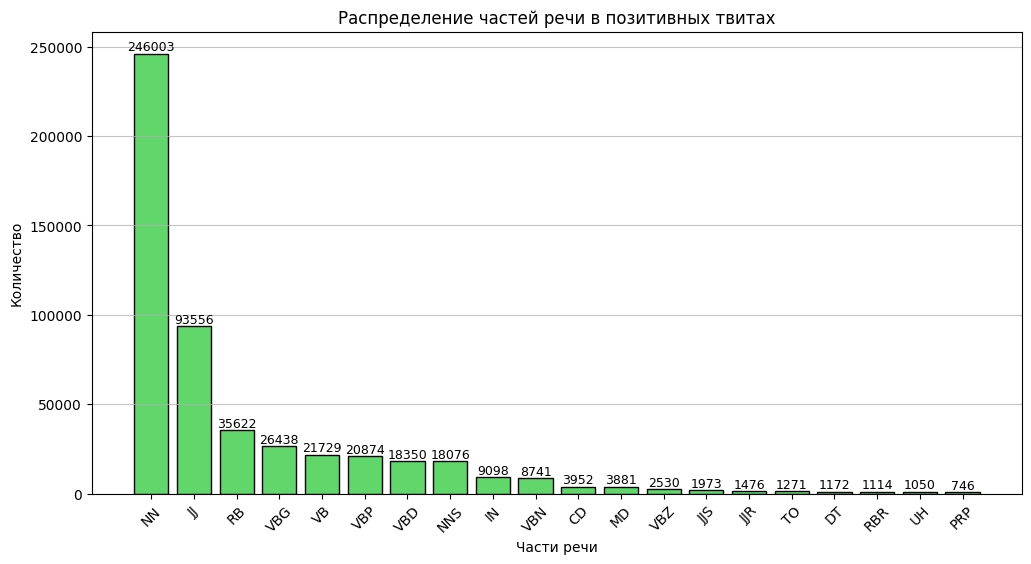

In [ ]:
plt.figure(figsize=(12, 6))
bars = plt.bar(df_pos_positive['Part of Speech'], df_pos_positive['Count'], color='#61d66b', edgecolor='black')
plt.title('Распределение частей речи в позитивных твитах')
plt.xlabel('Части речи')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             str(height), ha='center', va='bottom', fontsize=9)

plt.show()

**4.4.3. Распределение частей речи в негативных твитах**

In [ ]:
df_neg = df[df['feeling'] == 0]

In [ ]:
pos_counts_neg = Counter()
for tags in df_neg['pos_tags']:
    pos_counts_neg.update(tag for word, tag in tags)

In [ ]:
df_pos_negative = pd.DataFrame(pos_counts_neg.items(), columns=['Part of Speech', 'Count'])

In [ ]:
df_pos_negative

,Part of Speech,Count
0,VBG,27804
1,RP,663
2,NN,258745
3,VBP,21877
4,IN,10979
5,JJ,99053
6,VBD,25036
7,RB,40921
8,PRP,703
9,NNS,14564


In [ ]:
df_pos_negative = df_pos_negative.sort_values(by='Count', ascending=False).head(20)

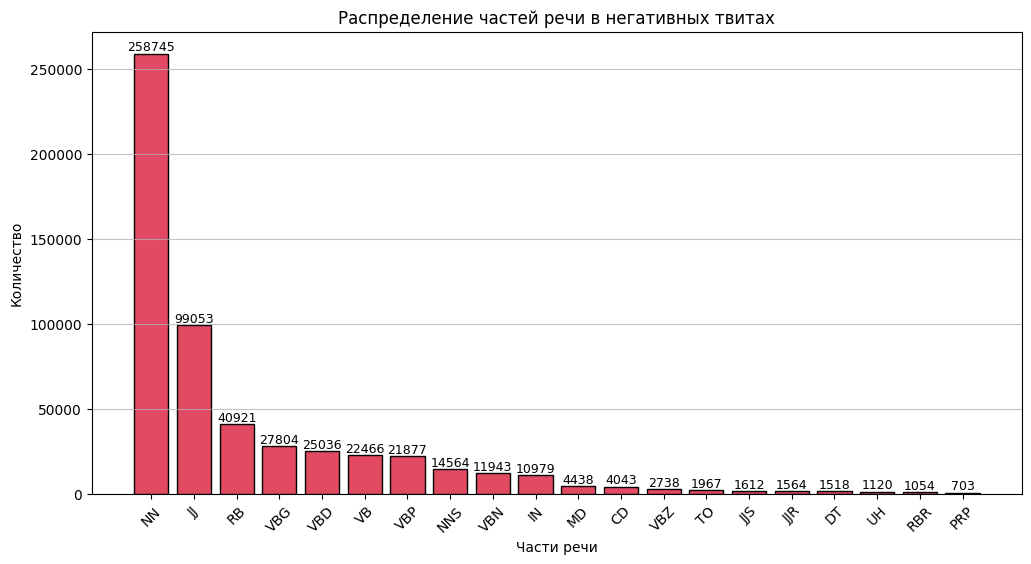

In [ ]:
plt.figure(figsize=(12, 6))
bars = plt.bar(df_pos_negative['Part of Speech'], df_pos_negative['Count'], color='#e24962', edgecolor='black')
plt.title('Распределение частей речи в негативных твитах')
plt.xlabel('Части речи')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             str(height), ha='center', va='bottom', fontsize=9)

plt.show()

Наиболее используемая часть речи -- существительное в единственном числе (NN). Оно встречается 502 451 раз во всех твитах. На втором месте по частоте использования расположены прилагательные (JJ), на третьем -- наречия (RB). Они встречаются 191 909 и 76 466 раз соответственно.

Самыми популярными словами в позитивных твитах стали im, good, day, love и get, в негативных -- im, day, go, get и cant.

***TO BE CONTINUED...***

# **5) TF-IDF, word2vec + t-SNE**

# **6) Облака слов**

### **6.1. Облака слов для каждой тональности**

In [ ]:
df['lemmatized_str'] = df['lemmatized'].apply(lambda x: ' '.join(x))

In [ ]:
df['lemmatized_str']

,lemmatized_str
0,starting back work today look like itll rainin...
1,sugar level dropping munchies setting luckily ...
2,yeah great summer break
3,hannah montana good going read twilight
4,aww fun last week
...,...
149980,great night tab im missing chad going bed
149981,night work church morning
149982,book terrible im used reading make belief teen...
149983,update miss update guy


In [ ]:
positive_tweets = ' '.join(df[df['feeling'] == 1]['lemmatized_str'])
negative_tweets = ' '.join(df[df['feeling'] == 0]['lemmatized_str'])

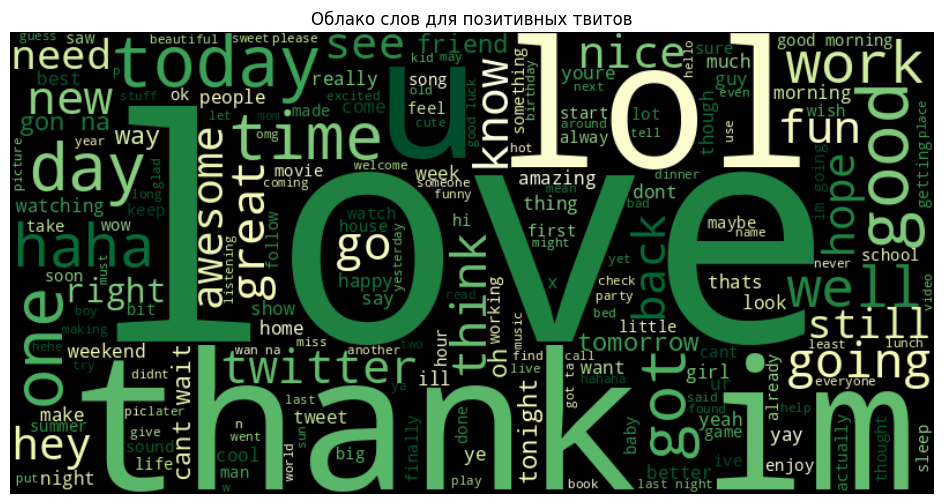

In [ ]:
wordcloud_pos = WordCloud(width=800, height=400, colormap='YlGn', background_color='black').generate(positive_tweets)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для позитивных твитов')
plt.show()

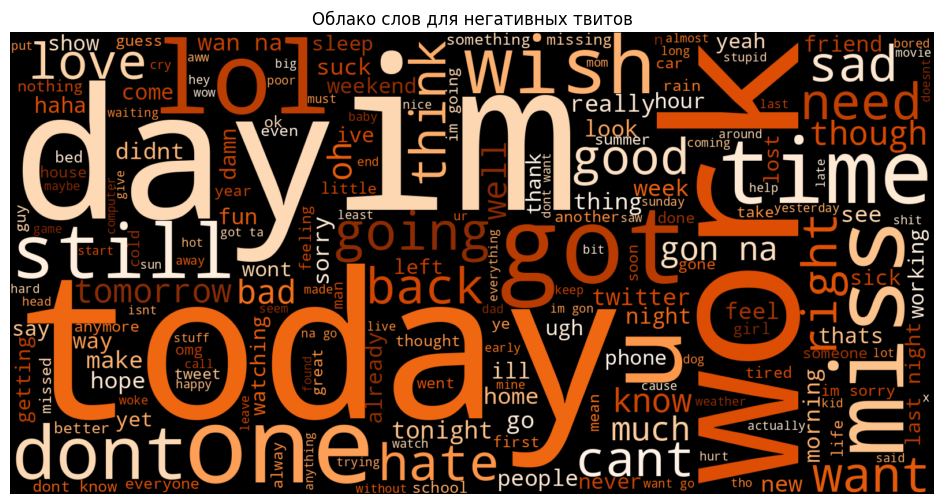

In [ ]:
wordcloud_neg = WordCloud(width=1600, height=800, colormap='Oranges_r', background_color='black').generate(negative_tweets)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для негативных твитов')
plt.show()

### **6.2. Топ-20 самых частых слов для каждой тональности**

In [ ]:
dict_pos = {} #Словарь: 'слова': кол-во (позитив)
for tweet in df[df['feeling'] == 1]['lemmatized_str']:
    words_pos = tweet.split()
    for word in words_pos:
        if word in dict_pos:
            dict_pos[word] += 1
        else:
            dict_pos[word] = 1

In [ ]:
dict_neg = {} #Словарь: 'слова': кол-во (негатив)
for tweet in df[df['feeling'] == 0]['lemmatized_str']:
    words_neg = tweet.split()
    for word in words_neg:
        if word in dict_neg:
            dict_neg[word] += 1
        else:
            dict_neg[word] = 1

In [ ]:
df_dict_pos = pd.DataFrame(list(dict_pos.items()), columns=['word', 'frequency']).nlargest(20, 'frequency')
df_dict_neg = pd.DataFrame(list(dict_neg.items()), columns=['word', 'frequency']).nlargest(20, 'frequency')

In [ ]:
df_dict_pos

,word,frequency
38,im,7200
16,good,5700
48,day,5098
250,love,4656
249,get,3585
190,like,3570
84,u,3568
129,thanks,3307
68,lol,3221
72,time,3151


In [ ]:
df_dict_neg

,word,frequency
35,im,9763
10,day,4863
95,go,4547
28,get,4441
175,cant,4207
134,dont,4187
2,work,4131
5,like,3845
51,got,3549
3,today,3518


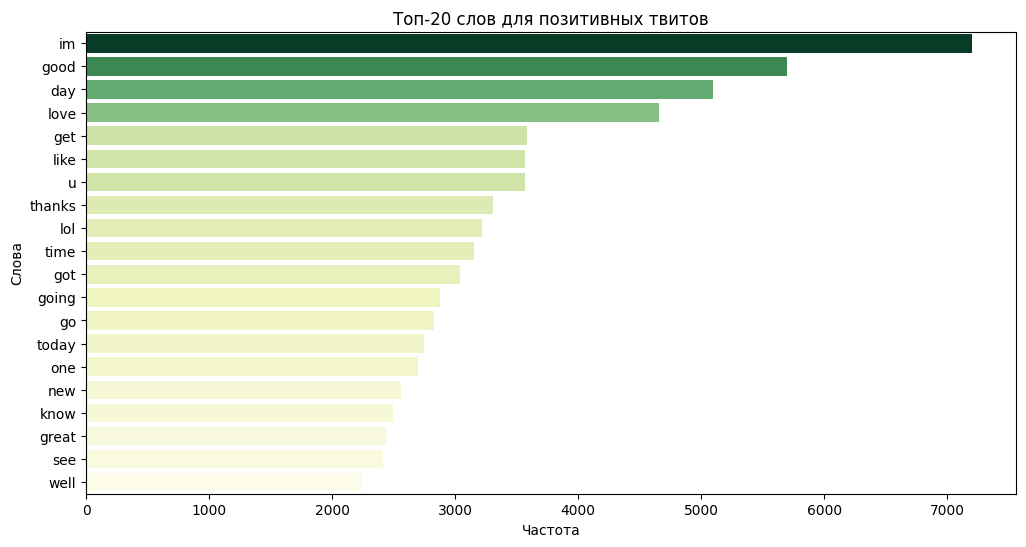

In [ ]:
#Топ-20 слов в позитивных твитах
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', hue='frequency', data=df_dict_pos, palette='YlGn', legend=False)
plt.title('Топ-20 слов для позитивных твитов')
plt.xlabel('Частота')
plt.ylabel('Cлова')
plt.show()

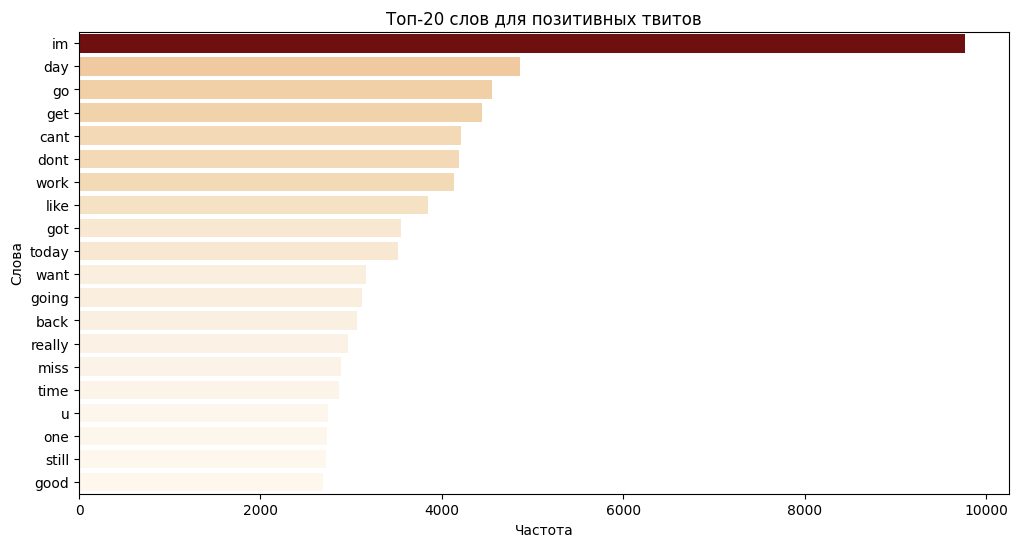

In [ ]:
#Топ-20 слов в негативных твитах
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', hue='frequency', data=df_dict_neg, palette='OrRd', legend=False)
plt.title('Топ-20 слов для позитивных твитов')
plt.xlabel('Частота')
plt.ylabel('Cлова')
plt.show()

# **7) Анализ n-грамм**

В главе 7 исследуются би- и триграммы для твитов позитивной и негативной тональностей.

### **7.1. Биграммы для позитивных твитов**

In [ ]:
bigrams_pos = []
for tweet in df[df['feeling'] == 1]['lemmatized_str']:
    words = tweet.split()
    for bigram in ngrams(words, 2):
        bigrams_pos.append(' '.join(bigram)) #Биграмма ---> Строка

In [ ]:
#Подсчёт частоты биграмм
dict_bigram_pos = {}
for bigram in bigrams_pos:
    if bigram in dict_bigram_pos:
        dict_bigram_pos[bigram] += 1
    else:
        dict_bigram_pos[bigram] = 1

In [ ]:
df_bigram_pos = pd.DataFrame(list(dict_bigram_pos.items()), columns=['bigram', 'frequency']).nlargest(20, 'frequency')

In [ ]:
df_bigram_pos

,bigram,frequency
525,cant wait,1005
1624,gon na,980
193,good morning,664
97,im going,456
2227,last night,452
130,wan na,425
1588,good luck,396
2088,got ta,338
1130,good night,325
2440,looking forward,313


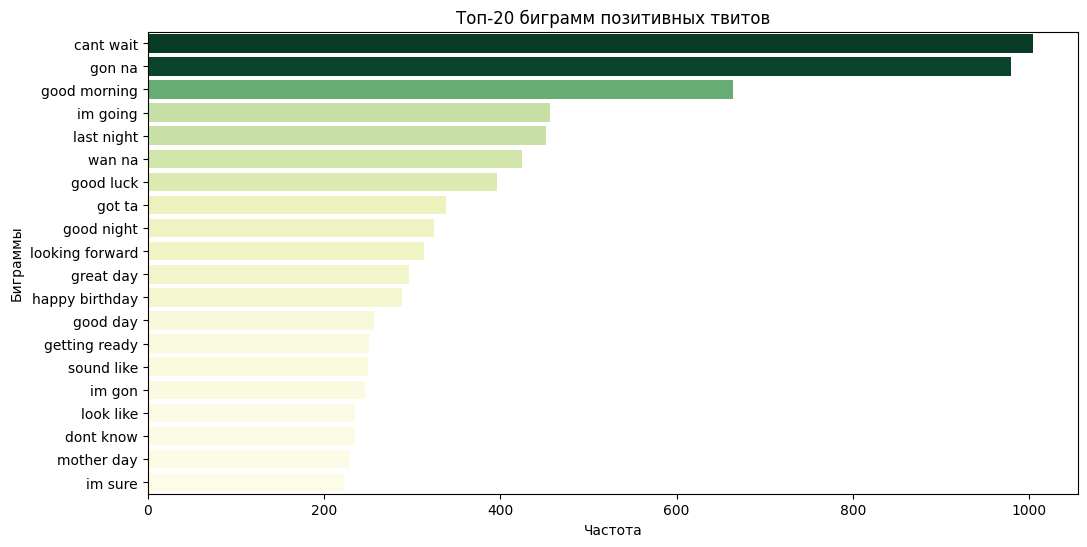

In [ ]:
#Топ-20 биграмм в позитивных твитах
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='bigram', hue='frequency', data=df_bigram_pos, palette='YlGn', legend=False)
plt.title('Топ-20 биграмм позитивных твитов')
plt.xlabel('Частота')
plt.ylabel('Биграммы')
plt.show()

### **7.2. Триграммы для позитивных твиттов**

In [ ]:
#Подсчёт триграмм для позитивных твитов
trigrams_pos = []
for tweet in df[df['feeling'] == 1]['lemmatized_str']:
    words = tweet.split()
    for trigram in ngrams(words, 3):
        trigrams_pos.append(' '.join(trigram))

In [ ]:
dict_trigram_pos = {}
for trigram in trigrams_pos:
    if trigram in dict_trigram_pos:
        dict_trigram_pos[trigram] += 1
    else:
        dict_trigram_pos[trigram] = 1

In [ ]:
df_trigram_pos = pd.DataFrame(list(dict_trigram_pos.items()), columns=['trigram', 'frequency']).nlargest(20, 'frequency')

In [ ]:
df_trigram_pos

,trigram,frequency
1399,im gon na,245
944,cant wait see,202
8347,happy mother day,152
6734,get follower day,128
6735,follower day using,128
6736,day using add,128
6737,using add everyone,128
6738,add everyone train,128
6739,everyone train pay,128
6740,train pay vip,128


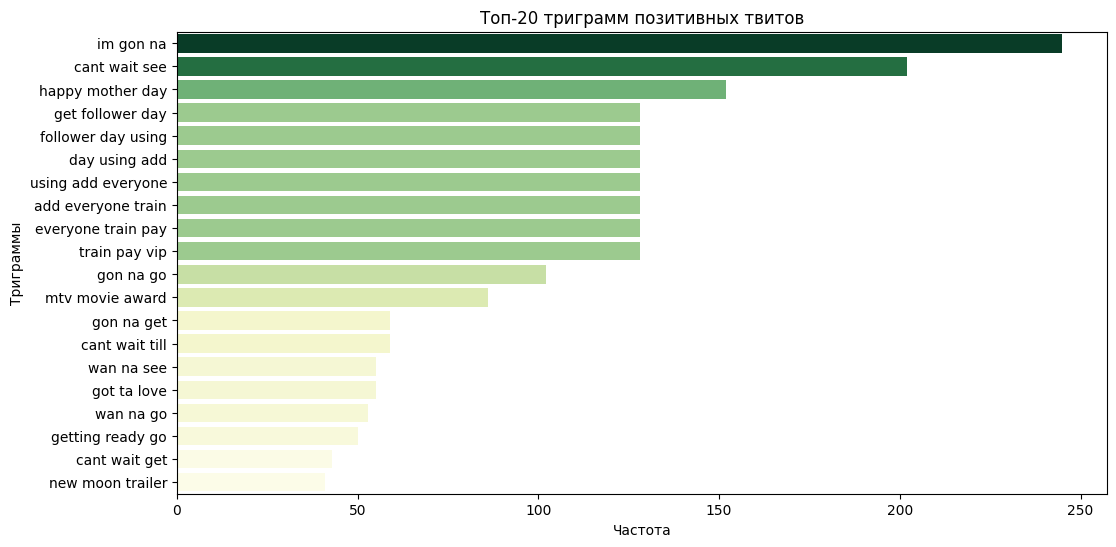

In [ ]:
#Топ-20 триграмм в позитивных твитах
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='trigram', hue='frequency', data=df_trigram_pos, palette='YlGn', legend=False)
plt.title('Топ-20 триграмм позитивных твитов')
plt.xlabel('Частота')
plt.ylabel('Триграммы')
plt.show()

### **7.3. Биграммы для негативных твитов**

In [ ]:
bigrams_neg = []
for tweet in df[df['feeling'] == 0]['lemmatized_str']:
    words = tweet.split()
    for bigram in ngrams(words, 2):
        bigrams_neg.append(' '.join(bigram)) #Биграмма ---> Строка

In [ ]:
#Подсчёт частоты биграмм
dict_bigram_neg = {}
for bigram in bigrams_neg:
    if bigram in dict_bigram_neg:
        dict_bigram_neg[bigram] += 1
    else:
        dict_bigram_neg[bigram] = 1

In [ ]:
df_bigram_neg = pd.DataFrame(list(dict_bigram_neg.items()), columns=['bigram', 'frequency']).nlargest(20, 'frequency')

In [ ]:
df_bigram_neg

,bigram,frequency
126,gon na,1207
790,wan na,1071
467,last night,690
972,feel like,614
200,im sorry,559
1290,wish could,549
139,dont know,540
67,im going,499
5163,dont want,462
50,got ta,455


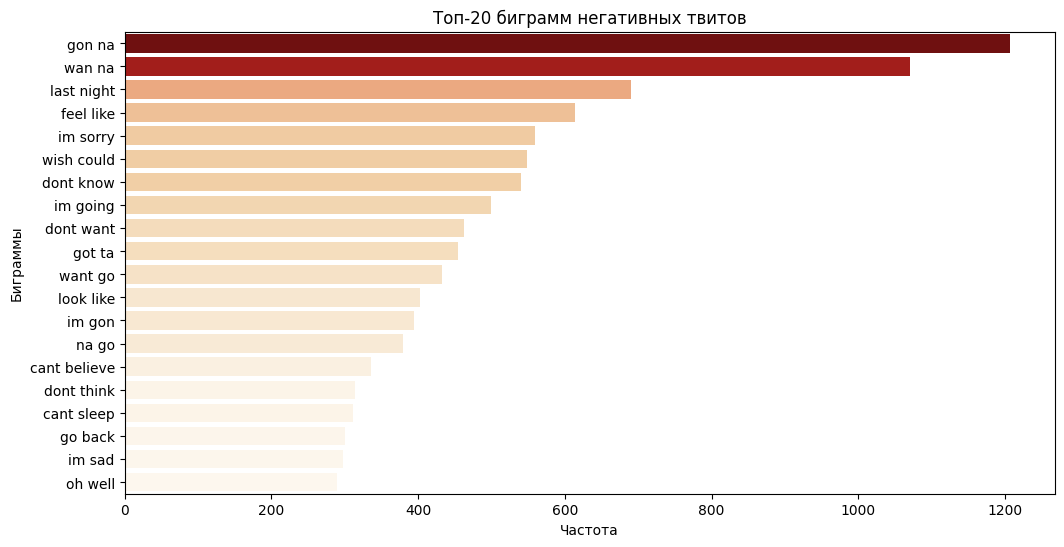

In [ ]:
#Топ-20 биграмм в негативных твитах
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='bigram', hue='frequency', data=df_bigram_neg, palette='OrRd', legend=False)
plt.title('Топ-20 биграмм негативных твитов')
plt.xlabel('Частота')
plt.ylabel('Биграммы')
plt.show()

### **7.4. Триграммы для негативных твитов**

In [ ]:
trigrams_neg = []
for tweet in df[df['feeling'] == 0]['lemmatized_str']:
    words = tweet.split()
    for trigram in ngrams(words, 3):
        trigrams_neg.append(' '.join(trigram))

In [ ]:
dict_trigram_neg = {}
for trigram in trigrams_neg:
    if trigram in dict_trigram_neg:
        dict_trigram_neg[trigram] += 1
    else:
        dict_trigram_neg[trigram] = 1

In [ ]:
df_trigram_neg = pd.DataFrame(list(dict_trigram_neg.items()), columns=['trigram', 'frequency']).nlargest(20, 'frequency')

In [ ]:
df_trigram_neg

,trigram,frequency
819,im gon na,389
670,wan na go,297
2755,dont wan na,235
3318,gon na miss,150
4636,dont want go,90
1407,wish could go,84
11246,gon na go,82
3360,hope feel better,80
5262,wan na see,80
12429,dont feel good,72


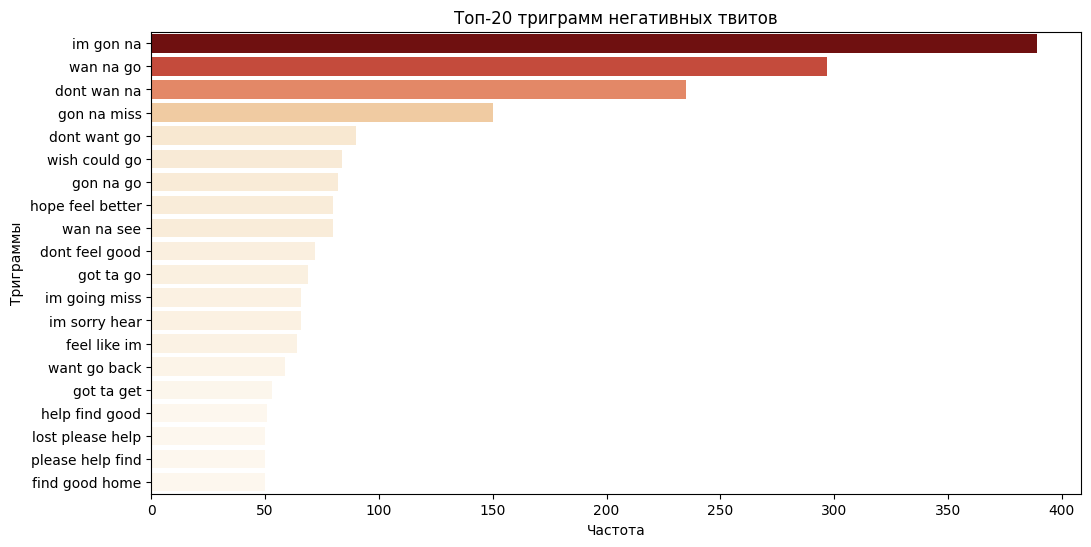

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='trigram', hue='frequency', data=df_trigram_neg, palette='OrRd', legend=False)
plt.title('Топ-20 триграмм негативных твитов')
plt.xlabel('Частота')
plt.ylabel('Триграммы')
plt.show()

Самые популярные биграммы в **позитивных твитах** -- *cant wait*, *gon na*, *good morning*, *im going* и *last night*. К наиболее частым позитивным триграммам относятся *im gon na*, *cant wait see*, *happy mother day*, *get follower day* и *follower day using*.

В **негативных твитах** распределение би- и триграмм несколько отличается от твитов положительной тональности:
1.  самые частые биграммы -- *gon na*, *wan na*, *last night*, *feel like* и *im sorry*;
2.  самые частые триграммы -- *im gon na*, *wan na go*, *dont wan na*, *gon na miss* и *dont want go*.

**Совпадающие биграммы** (но частота в зависимости от тональности различается): gon na и last night.

**Совпадающие триграммы** (частота в зависимости от тональности не меняется): im gon na.